In [90]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob, string
from climsim_utils.data_utils import *

In [2]:
grid_info = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/grid_info/ClimSim_low-res_grid-info.nc')
input_mean = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_mean_v2_rh_mc_pervar.nc')
input_max = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_max_v2_rh_mc_pervar.nc')
input_min = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_min_v2_rh_mc_pervar.nc')
output_scale = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/outputs/output_scale_std_lowerthred_v6.nc')
lbd_qn = np.loadtxt('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/qn_exp_lambda_large.txt', delimiter = ',')

data = data_utils(grid_info = grid_info,
                input_mean = input_mean, 
                input_max = input_max, 
                input_min = input_min, 
                output_scale = output_scale,
                qinput_log = False,
                normalize = False)
data.set_to_v6_vars()

lat = grid_info['lat'].values
lon = grid_info['lon'].values
lon = grid_info['lon'].values
lon = ((lon + 180) % 360) - 180
level = grid_info.lev.values
lat_bin_mids = data.lat_bin_mids

def area_mean(ds, var):
    arr = ds[var].values
    arr_reshaped = np.transpose(arr, (0,2,1))
    arr_zonal_mean = data.zonal_bin_weight_3d(arr_reshaped)
    return arr_zonal_mean

def zonal_diff(ds_sp, ds_nn, var):
    diff_zonal_mean = (area_mean(ds_nn, var) - area_mean(ds_sp, var)).mean(axis = 0)
    diff_zonal = xr.DataArray(diff_zonal_mean.T, dims = ['level', 'lat'], coords = {'level':level, 'lat': lat_bin_mids})
    return diff_zonal

def get_dp(ds):
    ps = ds['PS'][1:,:]
    p_interface = (ds['hyai'][1:,:] * ds['P0'][1:] + ds['hybi'][1:,:] * ds['PS'][1:,:]).values
    if p_interface.shape[0] == 61:
        p_interface = np.swapaxes(p_interface, 0, 1)
    dp = p_interface[:,1:61,:] - p_interface[:,0:60,:]
    return dp

def get_tcp_mean(ds, area_weight):
    cld = (ds['CLDICE'][1:,:,:] + ds['CLDLIQ'][1:,:,:]).values
    dp = get_dp(ds)
    tcp = np.sum(cld*dp, axis = 1)/9.81
    tcp_mean = np.average(tcp, weights = area_weight, axis = 1)
    return tcp_mean

grid_area = grid_info['area'].values
lev = grid_info['lev'].values
area_weight = grid_area/np.sum(grid_area)

ds_sp_1 = xr.open_mfdataset('/pscratch/sd/z/zeyuanhu/hu_etal2024_data_v2/data/h0/5year/mmf_ref/control_fullysp_jan_wmlio_r3.eam.h0.*.nc')
ds_sp_2 = xr.open_mfdataset('/pscratch/sd/z/zeyuanhu/hu_etal2024_data_v2/data/h0/5year/mmf_b/control_fullysp_jan_wmlio_r3_b.eam.h0.*.nc')

sp_dp = get_dp(ds_sp_1)
total_weight = sp_dp * area_weight[None, None, :]
total_weight = total_weight.mean(axis = 0)
total_weight = total_weight/total_weight.sum()

In [25]:
standard_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/online_runs/climsim3_ensembles_good/standard/five_year_runs/'

ds_unet_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'unet_seed_7/run/unet_seed_7.eam.h0.*.nc'))
ds_unet_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'unet_seed_43/run/unet_seed_43.eam.h0.*.nc'))
ds_unet_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'unet_seed_1024/run/unet_seed_1024.eam.h0.*.nc'))

ds_squeezeformer_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'squeezeformer_seed_7/run/squeezeformer_seed_7.eam.h0.*.nc'))
ds_squeezeformer_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'squeezeformer_seed_43/run/squeezeformer_seed_43.eam.h0.*.nc'))
ds_squeezeformer_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'squeezeformer_seed_1024/run/squeezeformer_seed_1024.eam.h0.*.nc'))

ds_pure_resLSTM_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'pure_resLSTM_seed_7/run/pure_resLSTM_seed_7.eam.h0.*.nc'))
ds_pure_resLSTM_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'pure_resLSTM_seed_43/run/pure_resLSTM_seed_43.eam.h0.*.nc'))
ds_pure_resLSTM_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'pure_resLSTM_seed_1024/run/pure_resLSTM_seed_1024.eam.h0.*.nc'))

ds_pao_model_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'pao_model_seed_7/run/pao_model_seed_7.eam.h0.*.nc'))
ds_pao_model_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'pao_model_seed_43/run/pao_model_seed_43.eam.h0.*.nc'))
ds_pao_model_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'pao_model_seed_1024/run/pao_model_seed_1024.eam.h0.*.nc'))

ds_convnext_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'convnext_seed_7/run/convnext_seed_7.eam.h0.*.nc'))
ds_convnext_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'convnext_seed_43/run/convnext_seed_43.eam.h0.*.nc'))
ds_convnext_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'convnext_seed_1024/run/convnext_seed_1024.eam.h0.*.nc'))

ds_encdec_lstm_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'encdec_lstm_seed_7/run/encdec_lstm_seed_7.eam.h0.*.nc'))
ds_encdec_lstm_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'encdec_lstm_seed_43/run/encdec_lstm_seed_43.eam.h0.*.nc'))
ds_encdec_lstm_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'encdec_lstm_seed_1024/run/encdec_lstm_seed_1024.eam.h0.*.nc'))

In [26]:
diff_zonal_unet_seed_7_T = zonal_diff(ds_sp_1, ds_unet_seed_7, 'T')
diff_zonal_squeezeformer_seed_7_T = zonal_diff(ds_sp_1, ds_squeezeformer_seed_7, 'T')
diff_zonal_pure_resLSTM_seed_7_T = zonal_diff(ds_sp_1, ds_pure_resLSTM_seed_7, 'T')
diff_zonal_pao_model_seed_7_T = zonal_diff(ds_sp_1, ds_pao_model_seed_7, 'T')
diff_zonal_convnext_seed_7_T = zonal_diff(ds_sp_1, ds_convnext_seed_7, 'T')
diff_zonal_encdec_lstm_seed_7_T = zonal_diff(ds_sp_1, ds_encdec_lstm_seed_7, 'T')

diff_zonal_unet_seed_43_T = zonal_diff(ds_sp_1, ds_unet_seed_7, 'T')
diff_zonal_squeezeformer_seed_43_T = zonal_diff(ds_sp_1, ds_squeezeformer_seed_7, 'T')
diff_zonal_pure_resLSTM_seed_43_T = zonal_diff(ds_sp_1, ds_pure_resLSTM_seed_7, 'T')
diff_zonal_pao_model_seed_43_T = zonal_diff(ds_sp_1, ds_pao_model_seed_7, 'T')
diff_zonal_convnext_seed_43_T = zonal_diff(ds_sp_1, ds_convnext_seed_7, 'T')
diff_zonal_encdec_lstm_seed_43_T = zonal_diff(ds_sp_1, ds_encdec_lstm_seed_7, 'T')

diff_zonal_unet_seed_1024_T = zonal_diff(ds_sp_1, ds_unet_seed_1024, 'T')
diff_zonal_squeezeformer_seed_1024_T = zonal_diff(ds_sp_1, ds_squeezeformer_seed_1024, 'T')
diff_zonal_pure_resLSTM_seed_1024_T = zonal_diff(ds_sp_1, ds_pure_resLSTM_seed_1024, 'T')
diff_zonal_pao_model_seed_1024_T = zonal_diff(ds_sp_1, ds_pao_model_seed_1024, 'T')
diff_zonal_convnext_seed_1024_T = zonal_diff(ds_sp_1, ds_convnext_seed_1024, 'T')
diff_zonal_encdec_lstm_seed_1024_T = zonal_diff(ds_sp_1, ds_encdec_lstm_seed_1024, 'T')

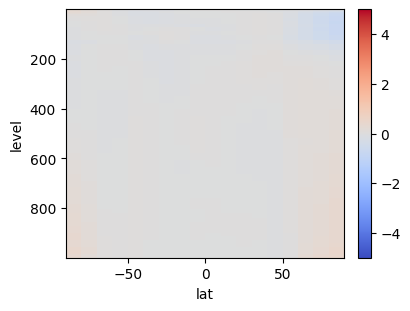

In [5]:
fig = plt.figure(figsize=(4, 3), constrained_layout=True)  # Increased width to accommodate third column
gs = fig.add_gridspec(1, 1)  # Changed to 1x1 grid
ax0 = fig.add_subplot(gs[0, 0])
diff_zonal_sp_2_T = zonal_diff(ds_sp_1, ds_sp_2, 'T')
diff_zonal_sp_2_T.plot(ax = ax0, vmin = -5, vmax = 5, cmap = 'coolwarm')
ax0.invert_yaxis()

In [6]:
def area_time_mean_3d(ds, var):
    arr = ds[var].values[1:,:,:]
    arr_reshaped = np.transpose(arr, (0,2,1))
    arr_zonal_mean = data.zonal_bin_weight_3d(arr_reshaped)
    arr_zonal_time_mean = arr_zonal_mean.mean(axis = 0)
    arr_zonal_time_mean = xr.DataArray(arr_zonal_time_mean.T, dims = ['hybrid pressure (hPa)', 'latitude'], coords = {'hybrid pressure (hPa)':level, 'latitude': lat_bin_mids})
    return arr_zonal_time_mean

def zonal_diff_3d(ds_sp, ds_nn, var):
    diff_zonal_mean = (area_mean(ds_nn, var) - area_mean(ds_sp, var)).mean(axis = 0)
    diff_zonal = xr.DataArray(diff_zonal_mean.T, dims = ['hybrid pressure (hPa)', 'latitude'], coords = {'hybrid pressure (hPa)':level, 'latitude': lat_bin_mids})
    return diff_zonal

wow = area_time_mean_3d(ds_sp_1, 'T')

In [7]:
# retrieve precomputed 1-year tropopause level distribution (we used as a microphysics constraint)
idx_p400_t10 = np.load('/pscratch/sd/z/zeyuanhu/hu_etal2024_data/microphysics_hourly/first_true_indices_p400_t10.npy')
for i in range(idx_p400_t10.shape[0]):
    for j in range(idx_p400_t10.shape[1]):
        idx_p400_t10[i,j] = level[int(idx_p400_t10[i,j])]

idx_p400_t10 = idx_p400_t10.mean(axis=0)
idx_p400_t10 = idx_p400_t10[np.newaxis,:]

idx_tropopause_zm = data.zonal_bin_weight_2d(idx_p400_t10)

In [182]:
def area_time_mean_3d(ds, var):
    arr = ds[var].values[1:,:,:]
    arr_reshaped = np.transpose(arr, (0,2,1))
    arr_zonal_mean = data.zonal_bin_weight_3d(arr_reshaped)
    arr_zonal_time_mean = arr_zonal_mean.mean(axis = 0)
    arr_zonal_time_mean = xr.DataArray(arr_zonal_time_mean.T, dims = ['hybrid pressure (hPa)', 'latitude'], coords = {'hybrid pressure (hPa)':level, 'latitude': lat_bin_mids})
    return arr_zonal_time_mean

def show_diff_state(ds_sp, ds_nn, comparison):    
    # List of variables and their settings
    variables = [
        {'var': 'T', 'var_title': 'T', 'scaling': 1., 'unit': 'K', 'diff_scale': 0.9, 'max_diff': 5},
        {'var': 'Q', 'var_title': 'Q', 'scaling': 1000., 'unit': 'g/kg', 'diff_scale': 1, 'max_diff': 1},
        {'var': 'U', 'var_title': 'U', 'scaling': 1., 'unit': 'm/s', 'diff_scale': 0.2, 'max_diff': 4},
        {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 40},
        {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 5}
    ]
    
    latitude_ticks = [-60, -30, 0, 30, 60]
    latitude_labels = ['60S', '30S', '0', '30N', '60N']
    
    # Create a figure with subplots
    fig, axs = plt.subplots(5, 3, figsize=(14, 12.5)) 
    # Generate the panel labels
    labels = [f"({letter})" for letter in string.ascii_lowercase[:15]]
    
    # Loop through each variable and its corresponding subplot row
    for idx, var_info in enumerate(variables):
        var = var_info['var']
        var_title = var_info['var_title']
        scaling = var_info['scaling']
        unit = var_info['unit']
        diff_scale = var_info['diff_scale']
    
        data_sp = scaling * area_time_mean_3d(ds_sp, var)
        data_nn = scaling * area_time_mean_3d(ds_nn, var)
        data_diff = data_nn - data_sp
        # Determine color scales
        vmax = max(abs(data_sp).max(), abs(data_nn).max())
        vmin = min(abs(data_sp).min(), abs(data_nn).min())
        # if var_info['diff_scale']:
        #     vmax_diff = abs(data_diff).max() * diff_scale
        #     vmin_diff = -vmax_diff
        vmax_diff = var_info['max_diff']
        vmin_diff = -vmax_diff
        # Plot each variable in its row
        data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
        axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
        axs[idx, 0].invert_yaxis()
    
        data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
        axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN')
        axs[idx, 1].invert_yaxis()
        axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot
    
        data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r', vmin=vmin_diff, vmax=vmax_diff)
        axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN - MMF')
        axs[idx, 2].invert_yaxis()
        axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot
        
        axs[idx, 0].set_xlabel('')
        axs[idx, 1].set_xlabel('')
        axs[idx, 2].set_xlabel('')
    
    tropopause_pressure = idx_tropopause_zm.flatten()  # Flatten to 1D array
    tropopause_latitude = data.lat_bin_mids  # Latitude values
    axs[4, 2].plot(tropopause_latitude, tropopause_pressure, 'k--')
    
    # Set these ticks and labels for each subplot
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
            ax.set_xticklabels(latitude_labels)  # Set the custom text labels
    plt.tight_layout()
    plt.suptitle(f'5 year zonal mean difference {(comparison)}')
    plt.subplots_adjust(top=0.93)
    # plt.savefig('zonal_mean_state_bias_v5_nopruning_noclass_drop1month_addtropopause.pdf', format='pdf', dpi=400)
    plt.show()

def show_diff_tendency(ds_sp, ds_nn, comparison):  
    # List of variables and their settings
    variables = [
        {'var': 'DTPHYS', 'var_title': 'dT/dt', 'scaling': 1., 'unit': 'K/s', 'diff_scale': 1, 'state_scale': 0.5},
        {'var': 'DQ1PHYS', 'var_title': 'dQ/dt', 'scaling': 1e3, 'unit': 'g/kg/s', 'diff_scale': 1, 'state_scale': 0.5},
        {'var': 'DUPHYS', 'var_title': 'dU/dt', 'scaling': 1., 'unit': 'm/s²', 'diff_scale': 0.25, 'state_scale': 0.16},
        {'var': 'DQnPHYS', 'var_title': 'dQn/dt', 'scaling': 1e6, 'unit': 'mg/kg/s', 'diff_scale': 0.5, 'state_scale': 0.6}
    ]
    
    # Combine dQc/dt and dQi/dt into dQn/dt
    ds_sp['DQnPHYS'] = ds_sp['DQ2PHYS'] + ds_sp['DQ3PHYS']
    ds_nn['DQnPHYS'] = ds_nn['DQ2PHYS'] + ds_nn['DQ3PHYS']
    
    # Create a figure with subplots (4 rows x 3 columns) to rotate the figure
    fig, axs = plt.subplots(4, 3, figsize=(14, 12))  # Adjust size as necessary
    # Generate the panel labels
    labels = [f"({letter})" for letter in string.ascii_lowercase[:12]]
    
    # Loop through each variable and its corresponding subplot position
    for idx, var_info in enumerate(variables):
        var = var_info['var']
        var_title = var_info['var_title']
        scaling = var_info['scaling']
        unit = var_info['unit']
        diff_scale = var_info['diff_scale']
        state_scale = var_info['state_scale']
    
        # Compute the means and differences for plots
        data_sp = scaling * area_time_mean_3d(ds_sp, var)
        data_nn = scaling * area_time_mean_3d(ds_nn, var)
        data_diff = data_nn - data_sp
    
        # Determine color scales
        vmax = max(abs(data_sp).max(), abs(data_nn).max())
        vmin = min(abs(data_sp).min(), abs(data_nn).min())
        
        vmax = max(abs(vmax), abs(vmin)) * state_scale
        vmin = -vmax
        
        # Plot MMF for each variable in the first row
        data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axs[idx, 0].set_title(f'{labels[idx*3]} {var_title} ({unit}): MMF')
        axs[idx, 0].invert_yaxis()
    
        # Plot NN for each variable in the second row
        data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axs[idx, 1].set_title(f'{labels[idx*3 + 1]} {var_title} ({unit}): NN')
        axs[idx, 1].invert_yaxis()
    
        # Plot NN-MMF for each variable in the third row
        vmax_diff = max(abs(data_diff).max(), abs(data_diff).min()) * diff_scale
        vmin_diff = -vmax_diff
        data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r', vmin=vmin_diff, vmax=vmax_diff)
        axs[idx, 2].set_title(f'{labels[idx*3 + 2]} {var_title} ({unit}): NN - MMF')
        axs[idx, 2].invert_yaxis()
    
        # Clear x-labels to clean up plot
        axs[idx, 0].set_xlabel('')
        axs[idx, 1].set_xlabel('')
        axs[idx, 2].set_xlabel('')
        
        if idx > 0:
            axs[idx, 0].set_ylabel('')  # Clear the y-label to clean up plot
            axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot
            axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot
    
    # Set these ticks and labels for each subplot
    latitude_ticks = [-60, -30, 0, 30, 60]
    latitude_labels = ['60S', '30S', '0', '30N', '60N']
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
            ax.set_xticklabels(latitude_labels)  # Set the custom text labels
    plt.tight_layout()
    plt.suptitle(f'5 year zonal mean difference {(comparison)}')
    plt.subplots_adjust(top=0.93)
    # plt.savefig('zonal_mean_tendency_bias_reduced_nopruning_noclass_wdiff_vertical_drop1month.pdf', format='pdf', dpi=400)
    plt.show()

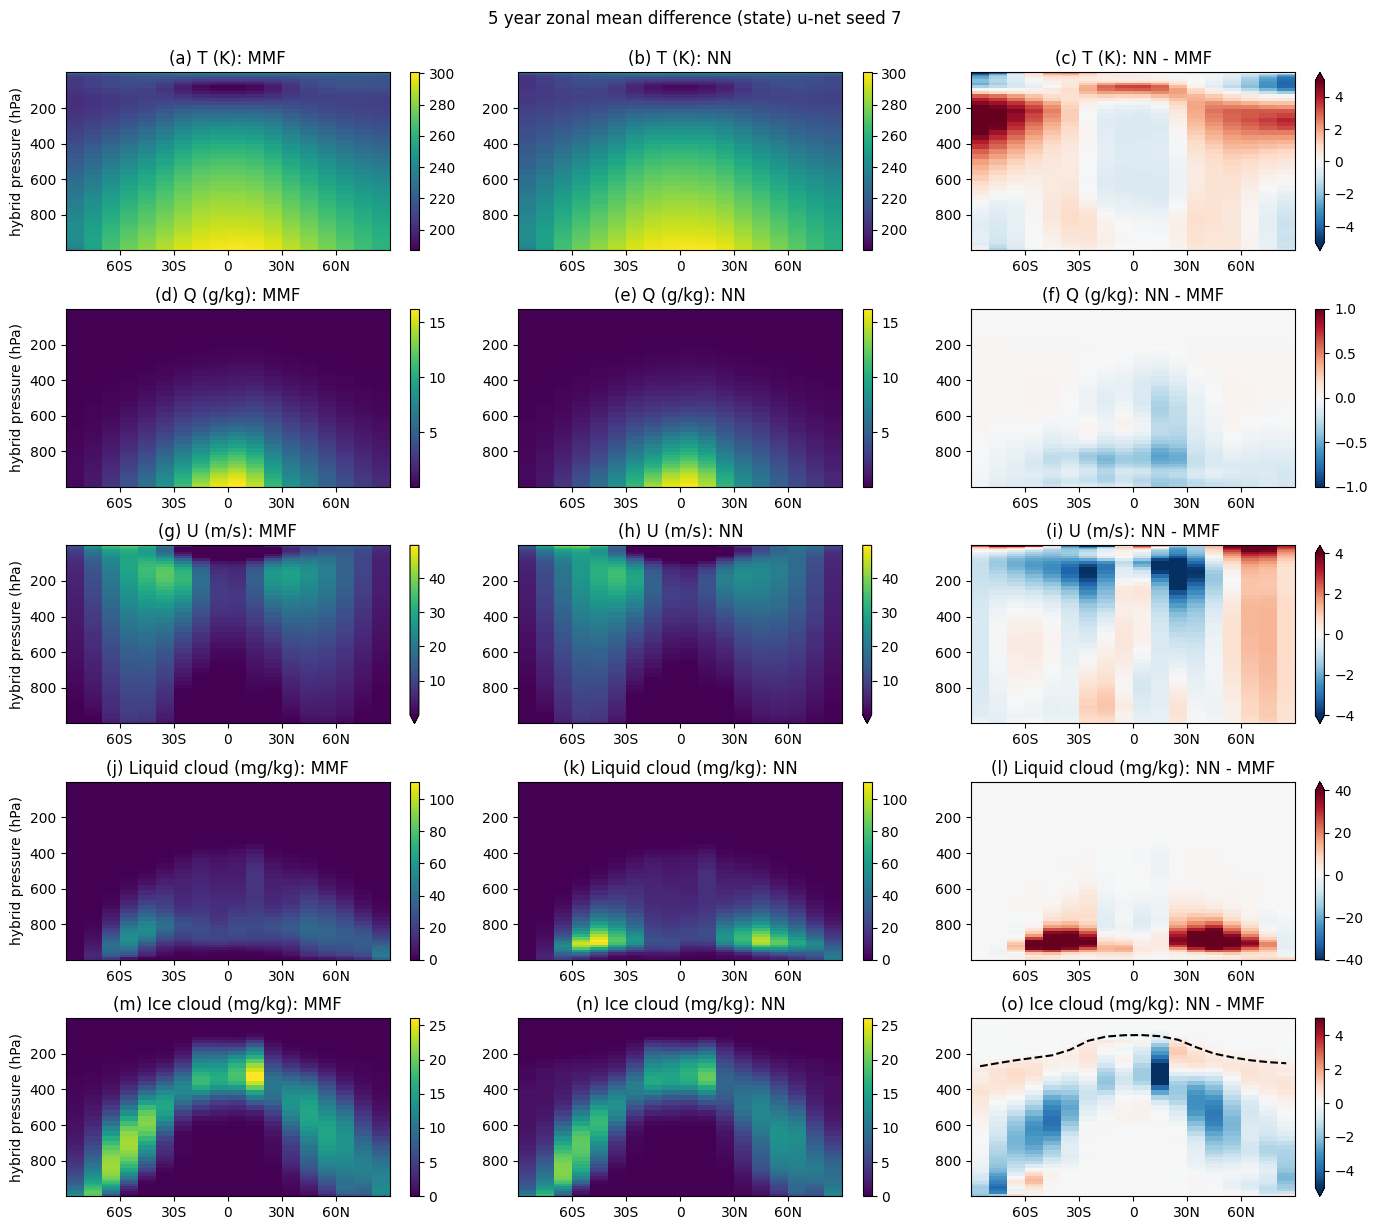

In [153]:
show_diff_state(ds_sp_1, ds_unet_seed_7, '(state) u-net seed 7')

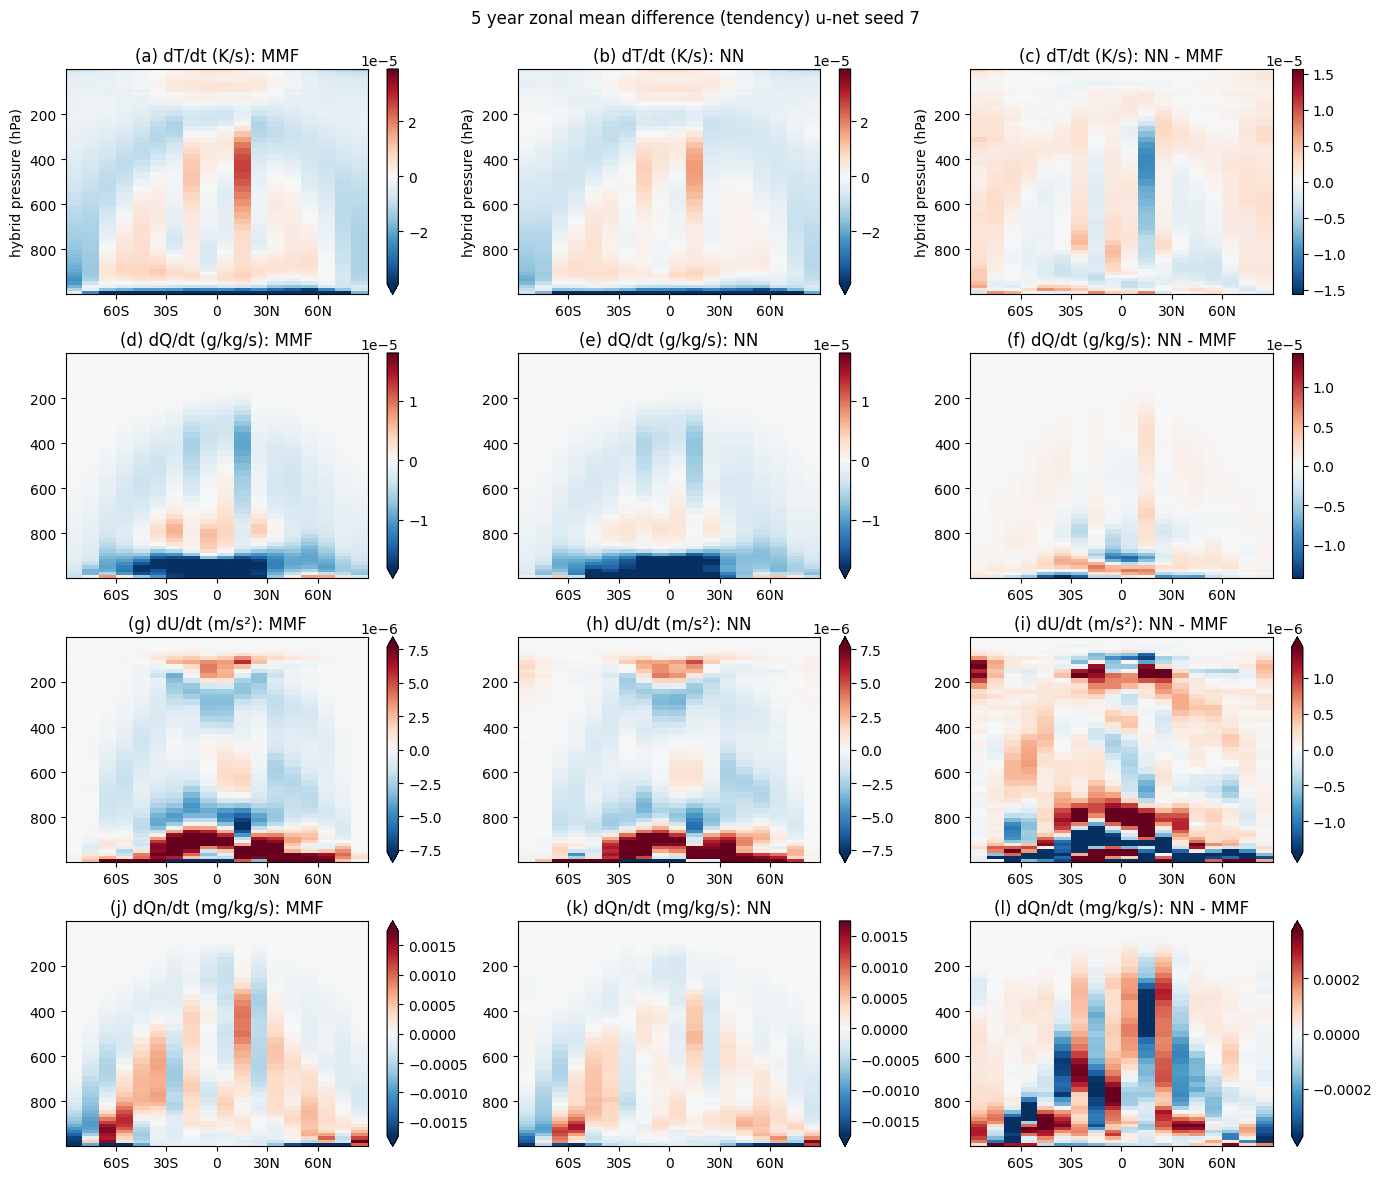

In [183]:
show_diff_tendency(ds_sp_1, ds_unet_seed_7, '(tendency) u-net seed 7')

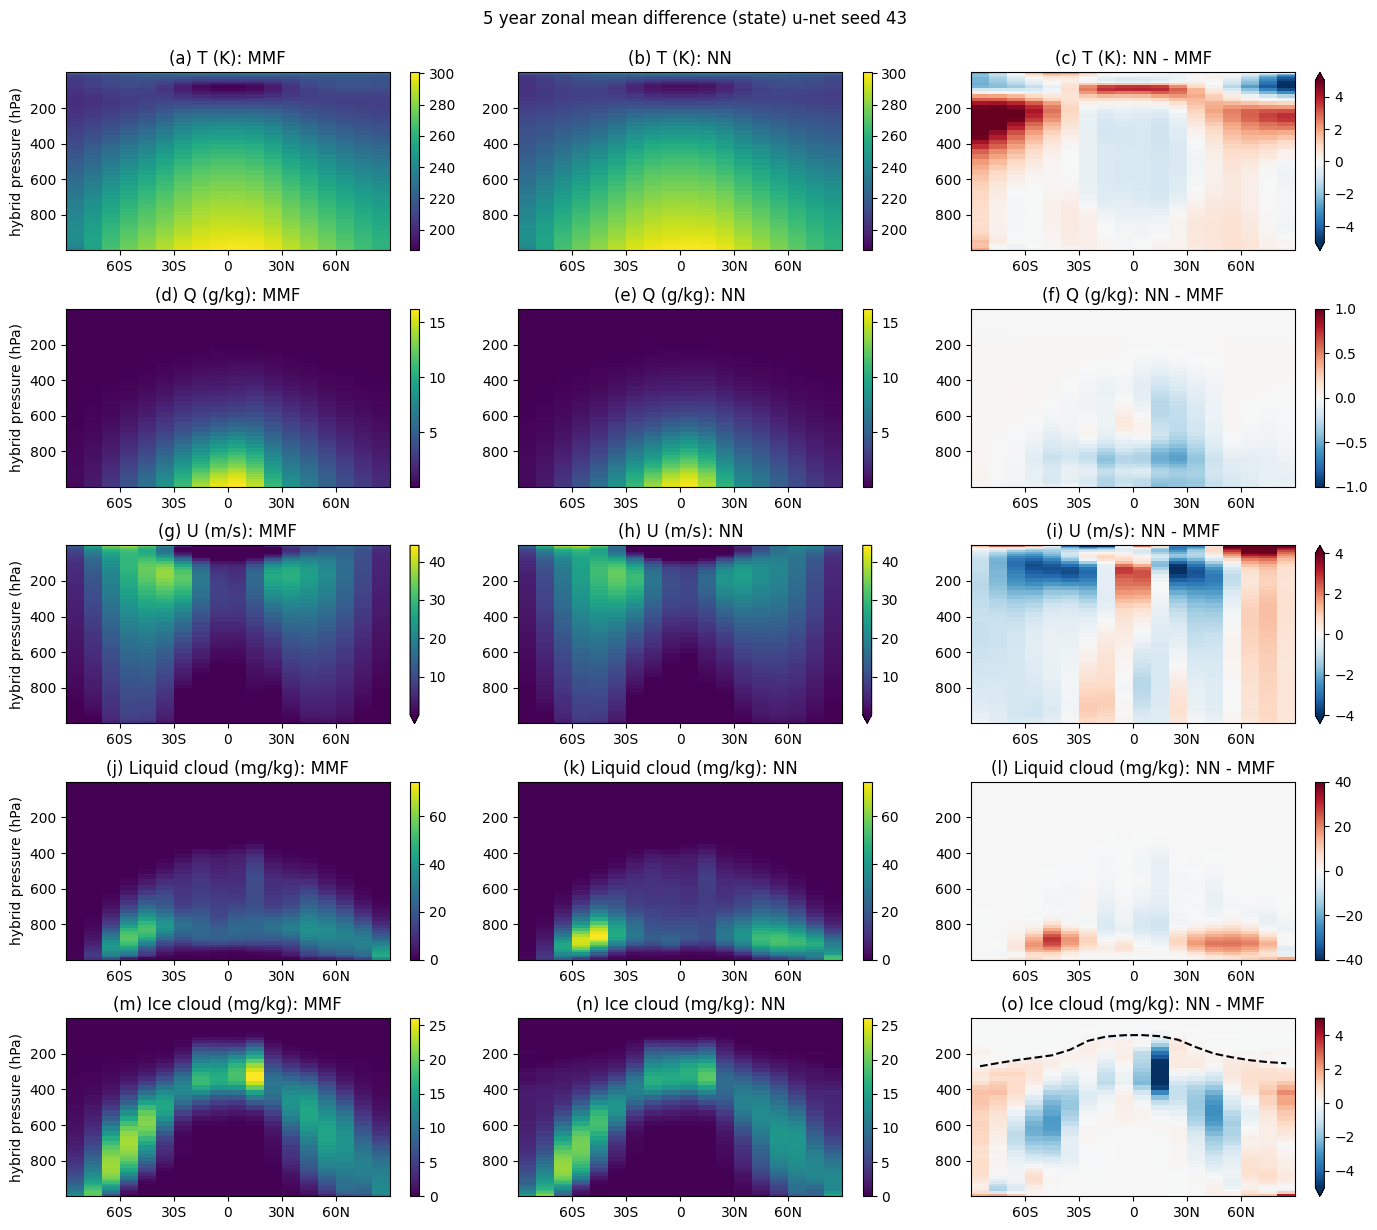

In [155]:
show_diff_state(ds_sp_1, ds_unet_seed_43, '(state) u-net seed 43')

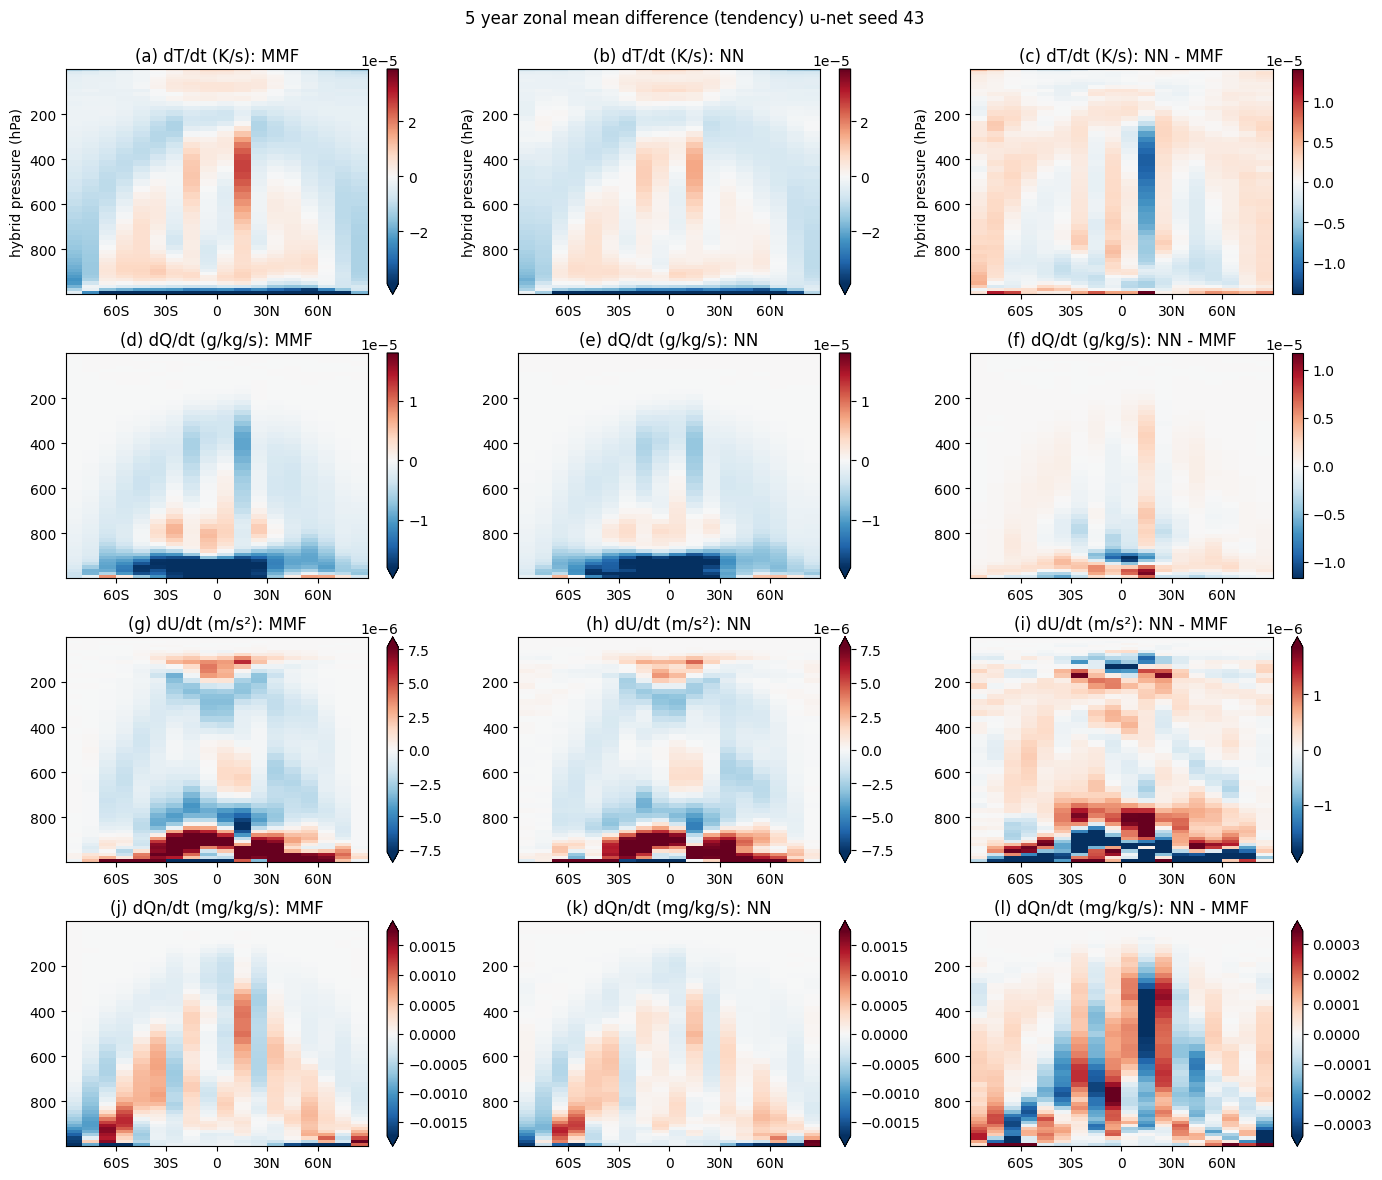

In [184]:
show_diff_tendency(ds_sp_1, ds_unet_seed_43, '(tendency) u-net seed 43')

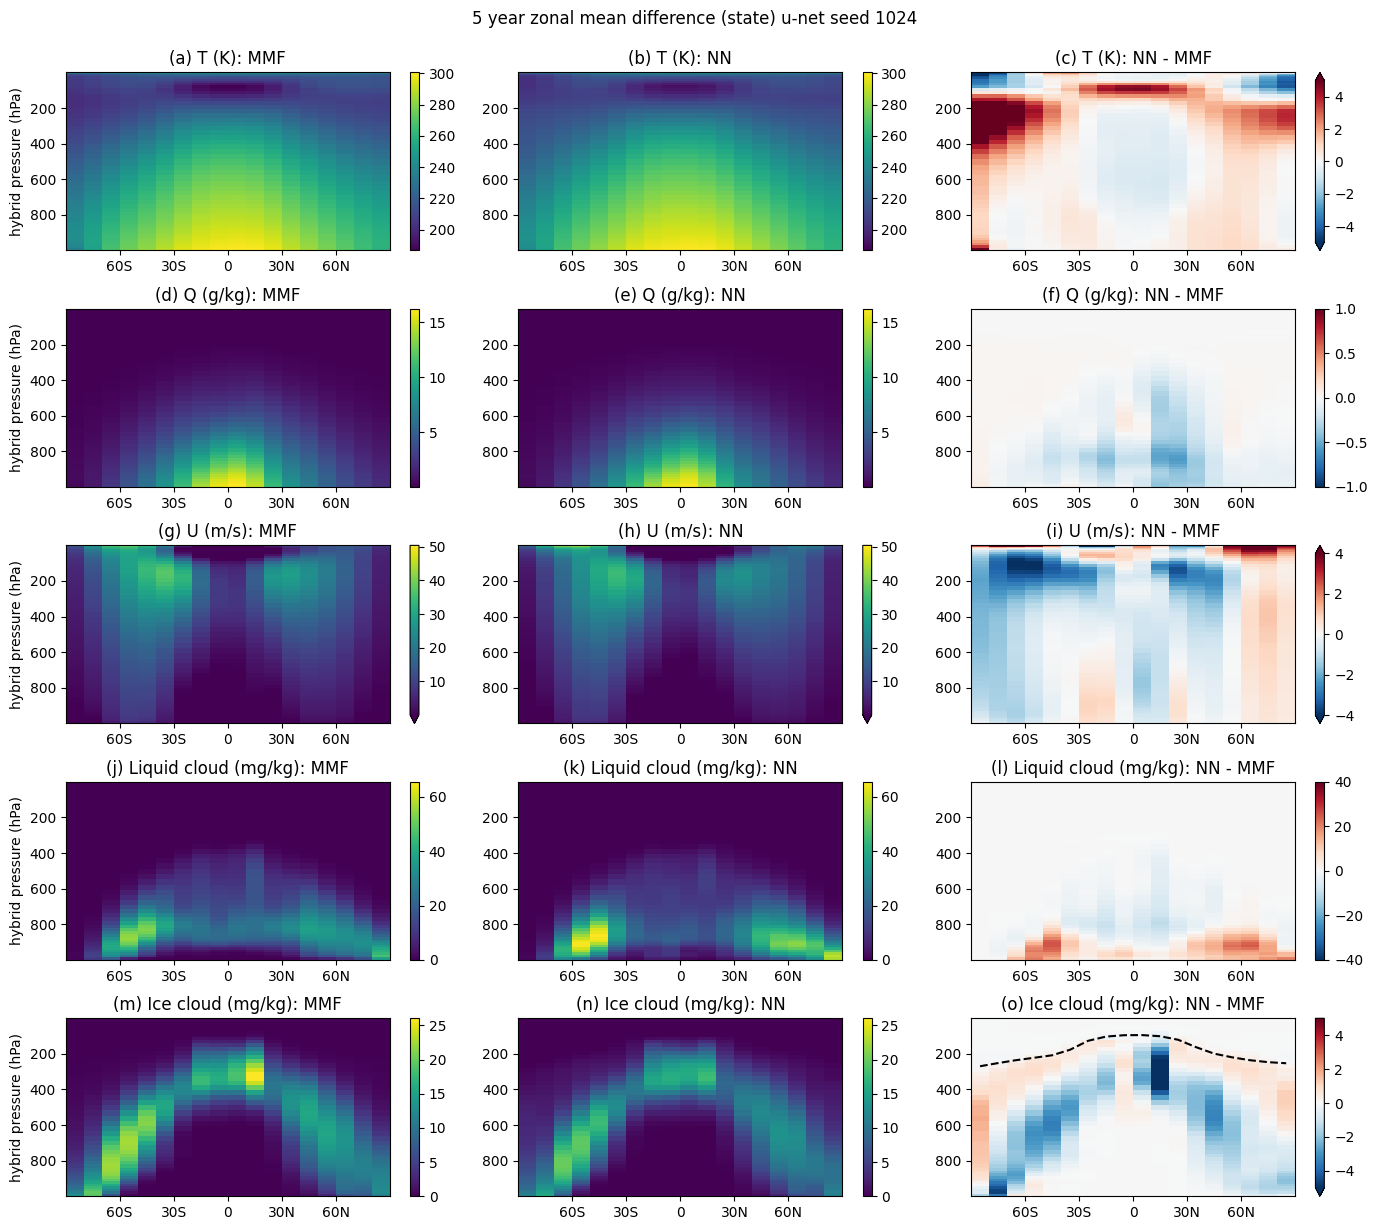

In [157]:
show_diff_state(ds_sp_1, ds_unet_seed_1024, '(state) u-net seed 1024')

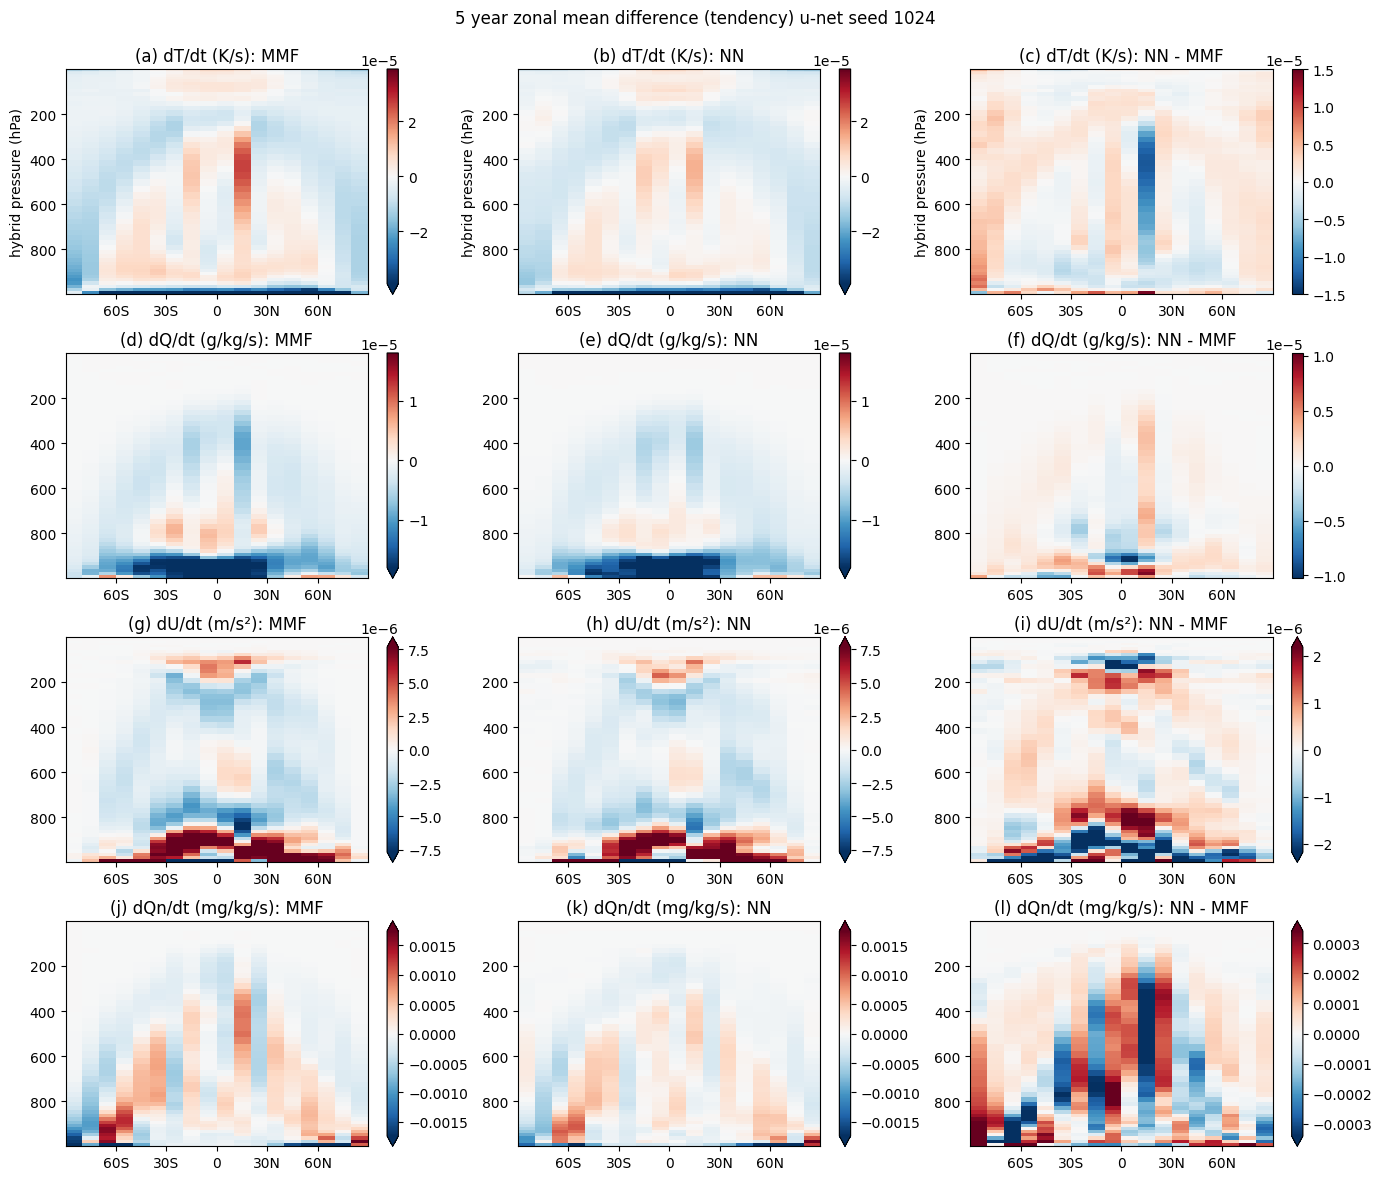

In [185]:
show_diff_tendency(ds_sp_1, ds_unet_seed_1024, '(tendency) u-net seed 1024')

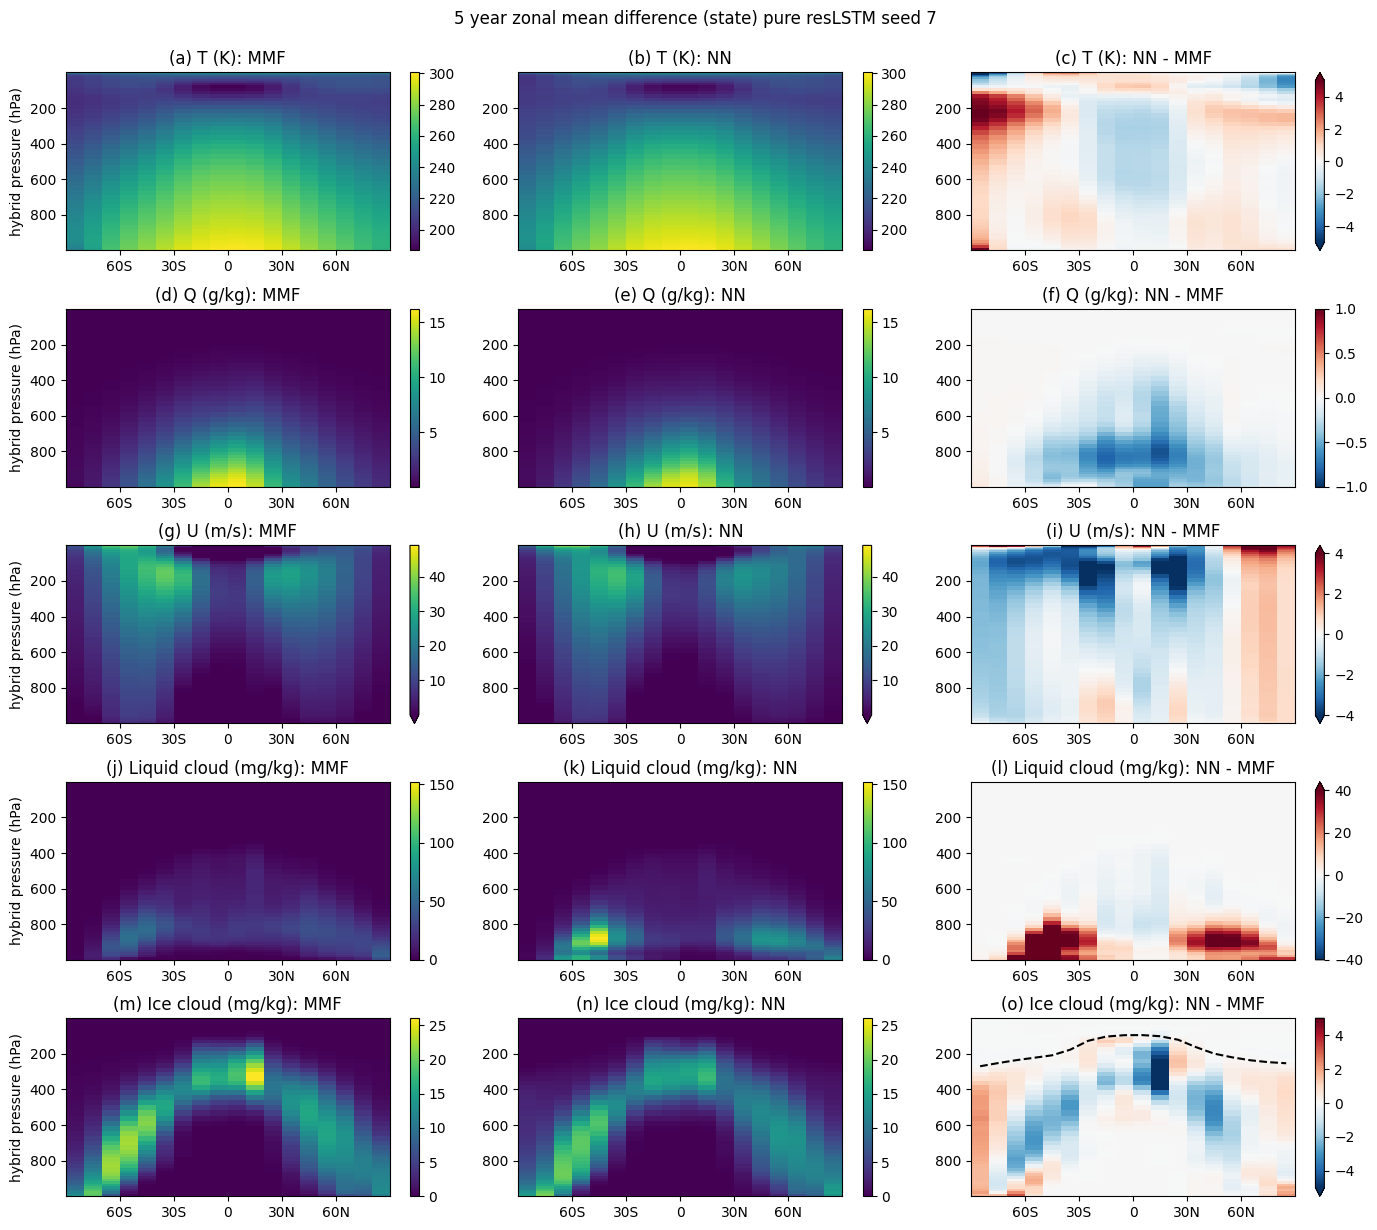

In [159]:
show_diff_state(ds_sp_1, ds_pure_resLSTM_seed_7, '(state) pure resLSTM seed 7')

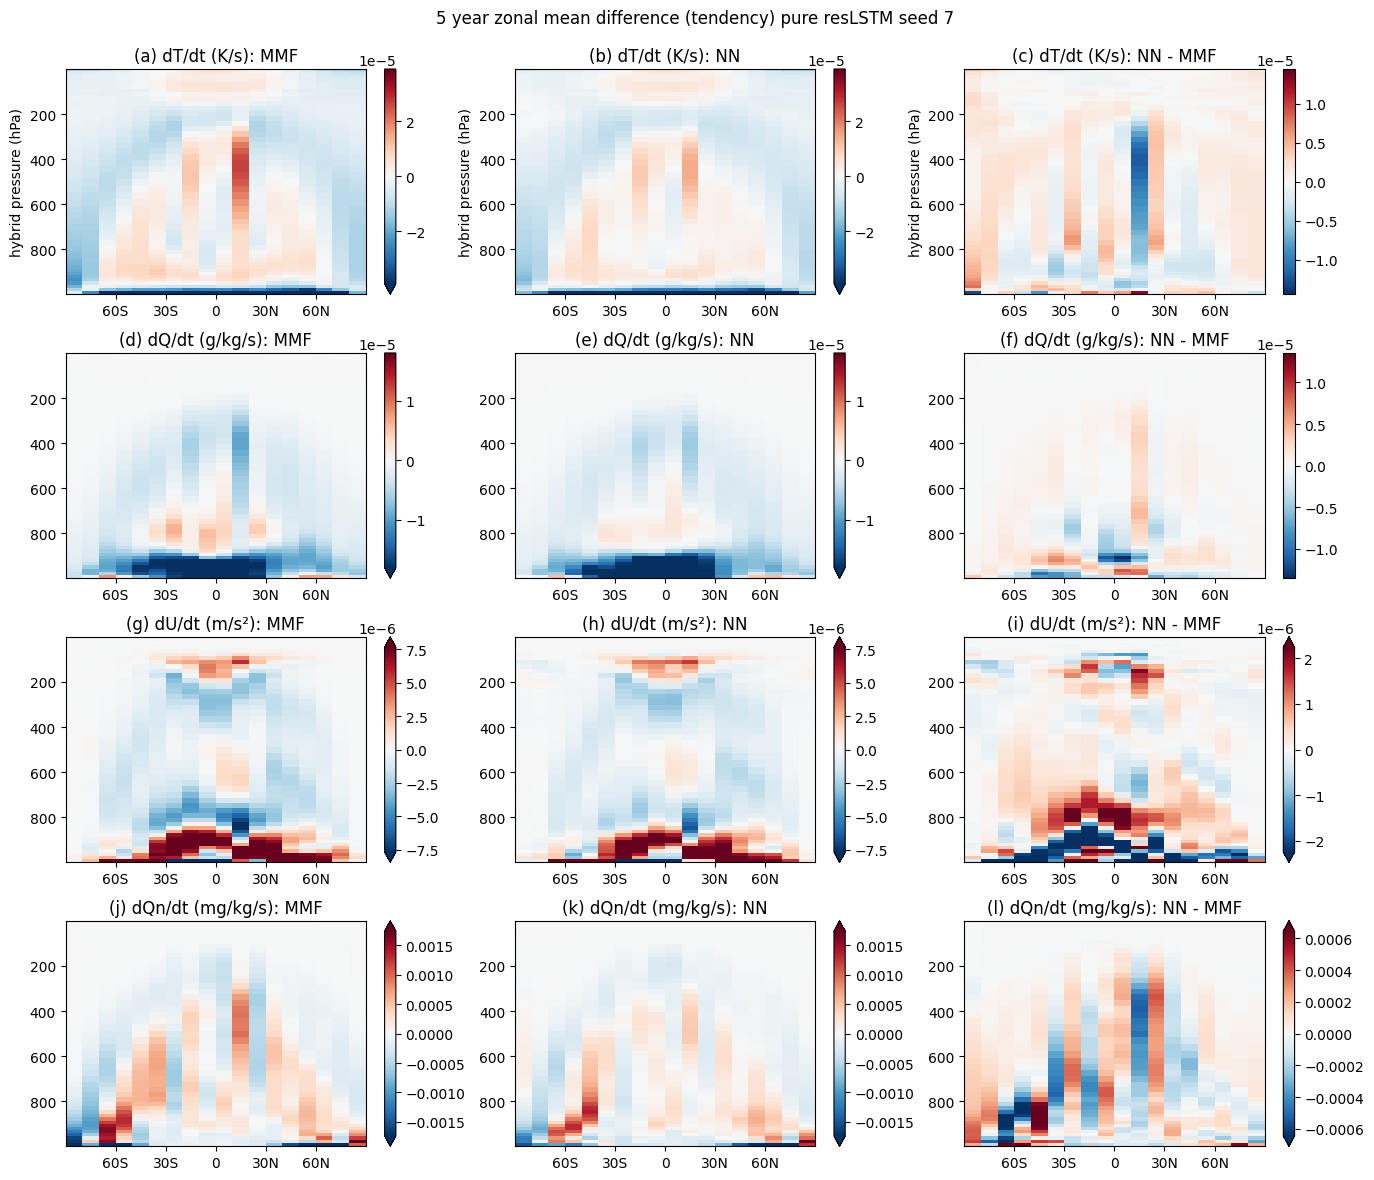

In [186]:
show_diff_tendency(ds_sp_1, ds_pure_resLSTM_seed_7, '(tendency) pure resLSTM seed 7')

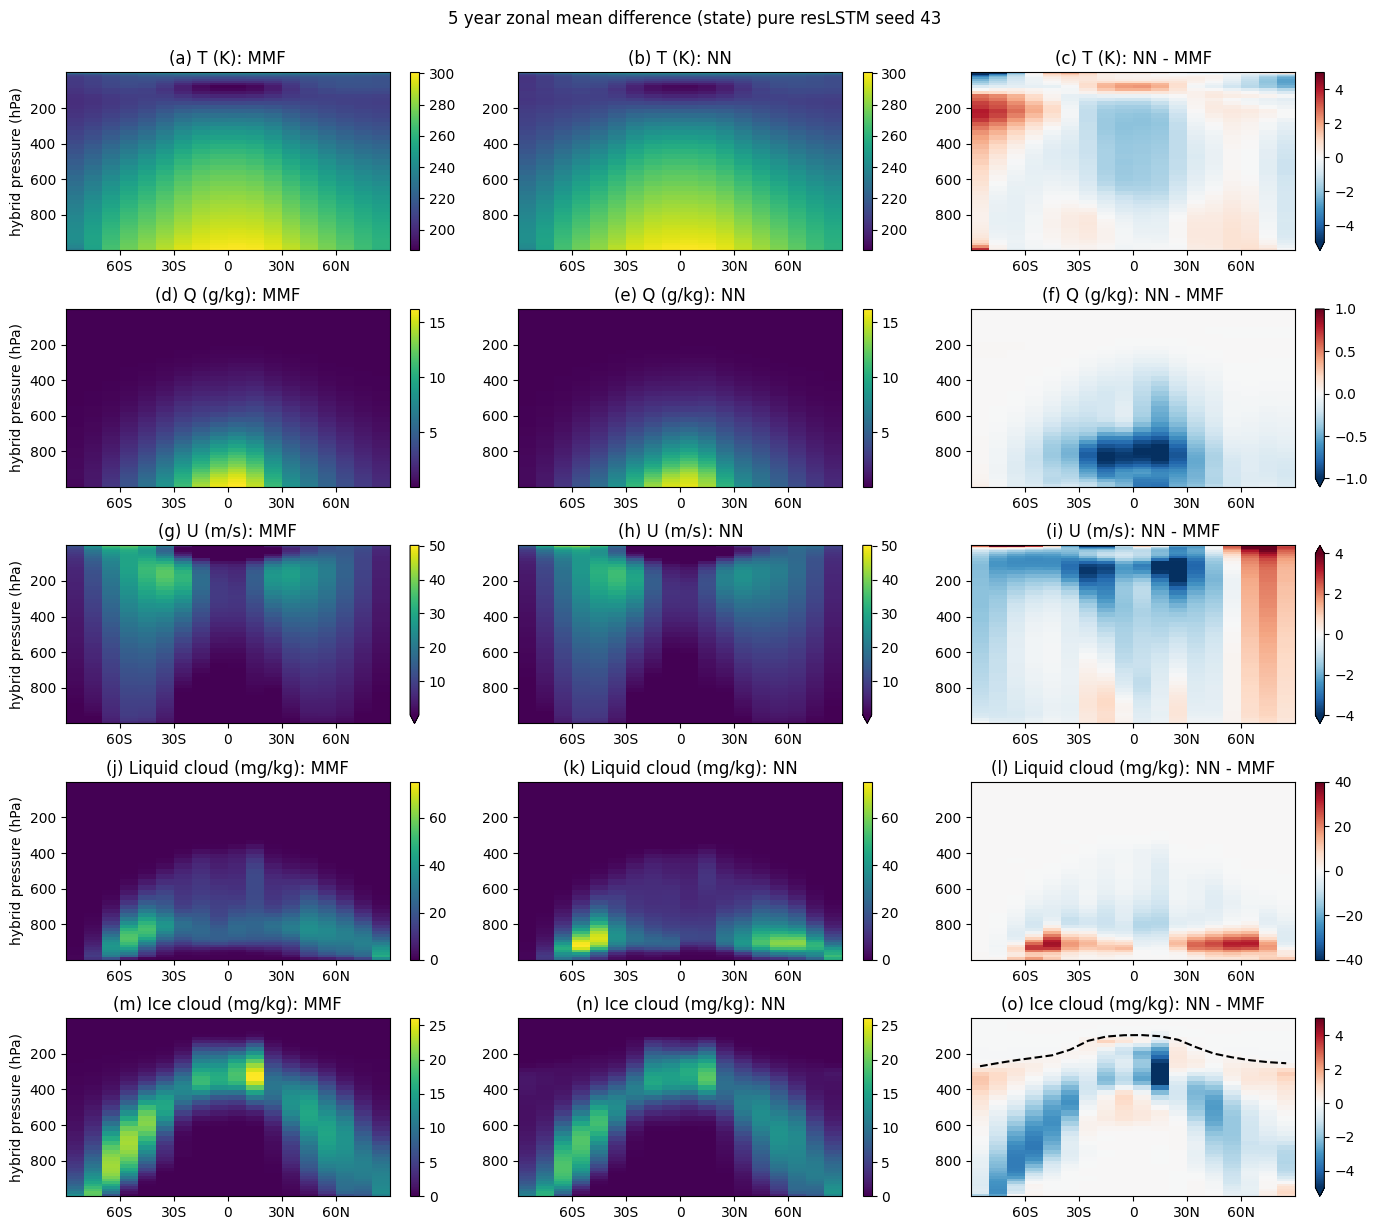

In [161]:
show_diff_state(ds_sp_1, ds_pure_resLSTM_seed_43, '(state) pure resLSTM seed 43')

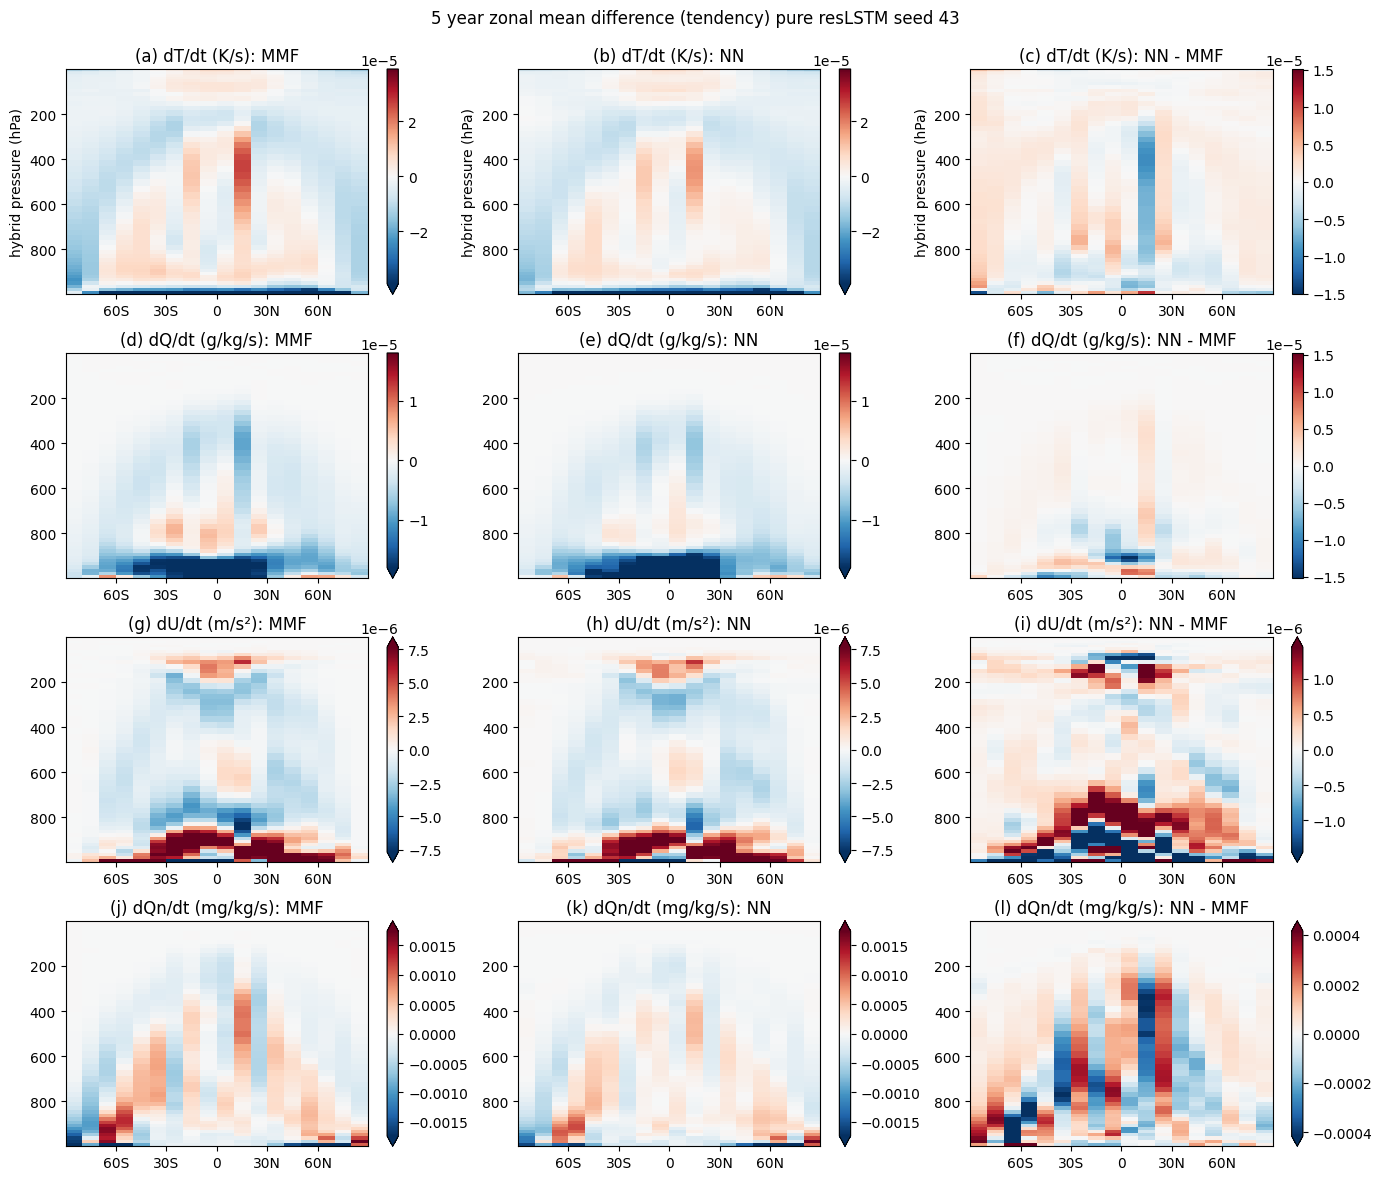

In [187]:
show_diff_tendency(ds_sp_1, ds_pure_resLSTM_seed_43, '(tendency) pure resLSTM seed 43')

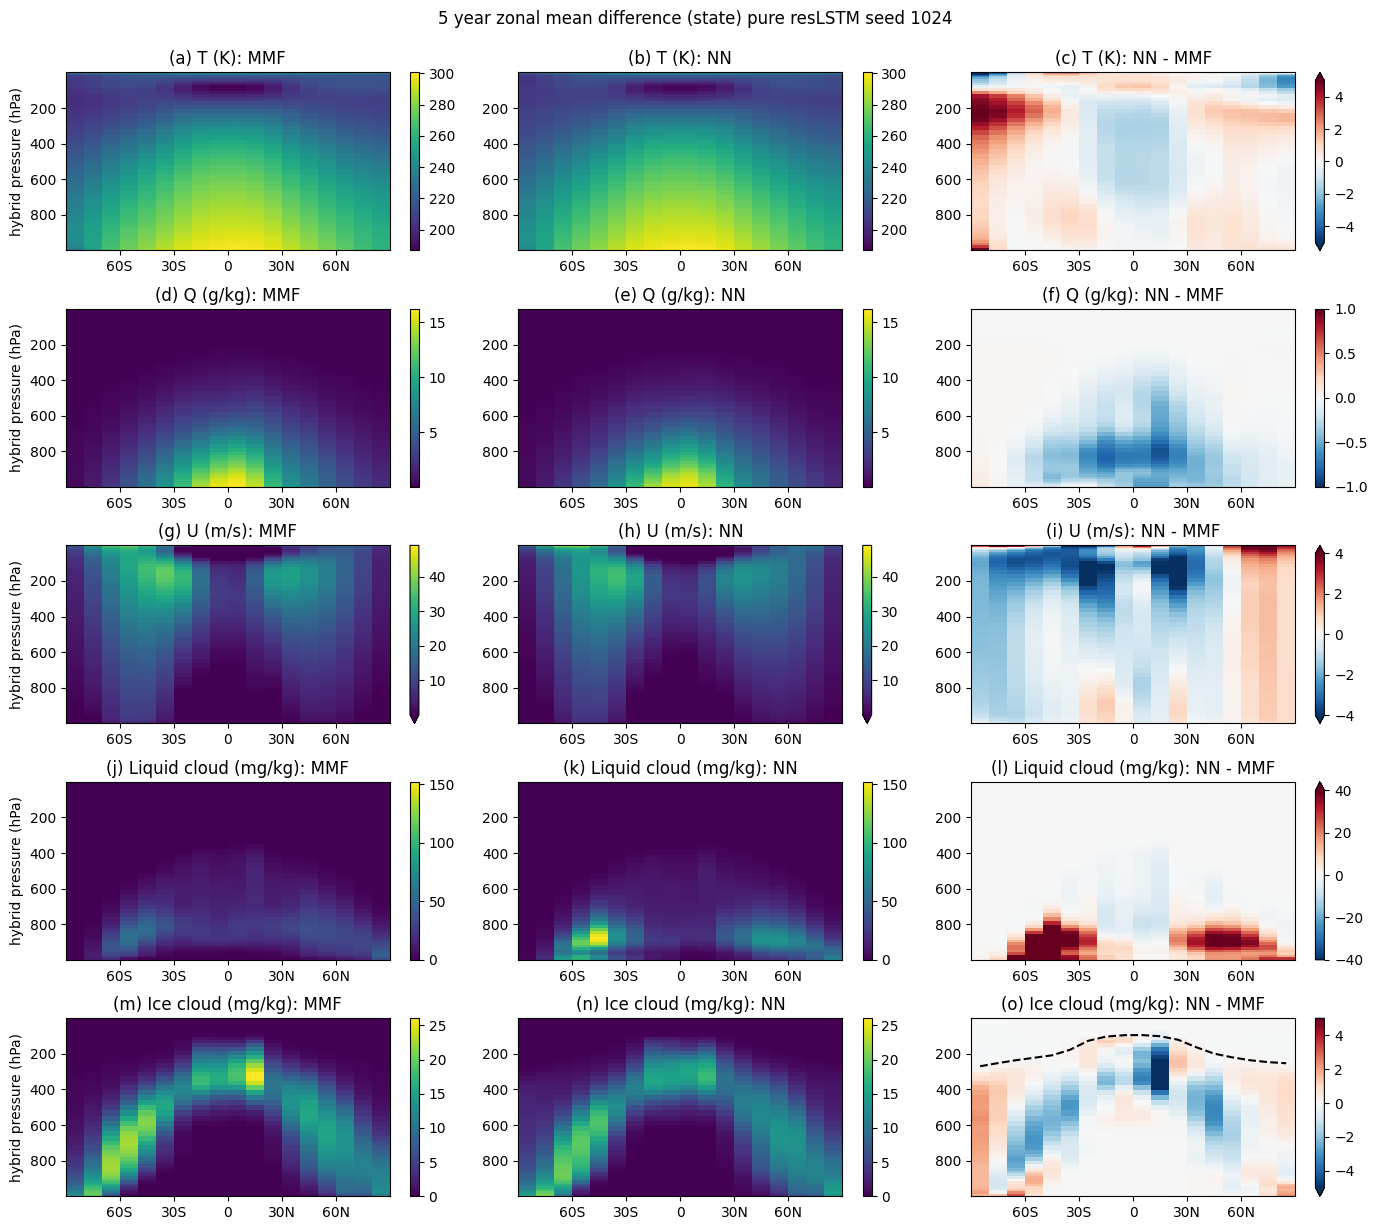

In [163]:
show_diff_state(ds_sp_1, ds_pure_resLSTM_seed_7, '(state) pure resLSTM seed 1024')

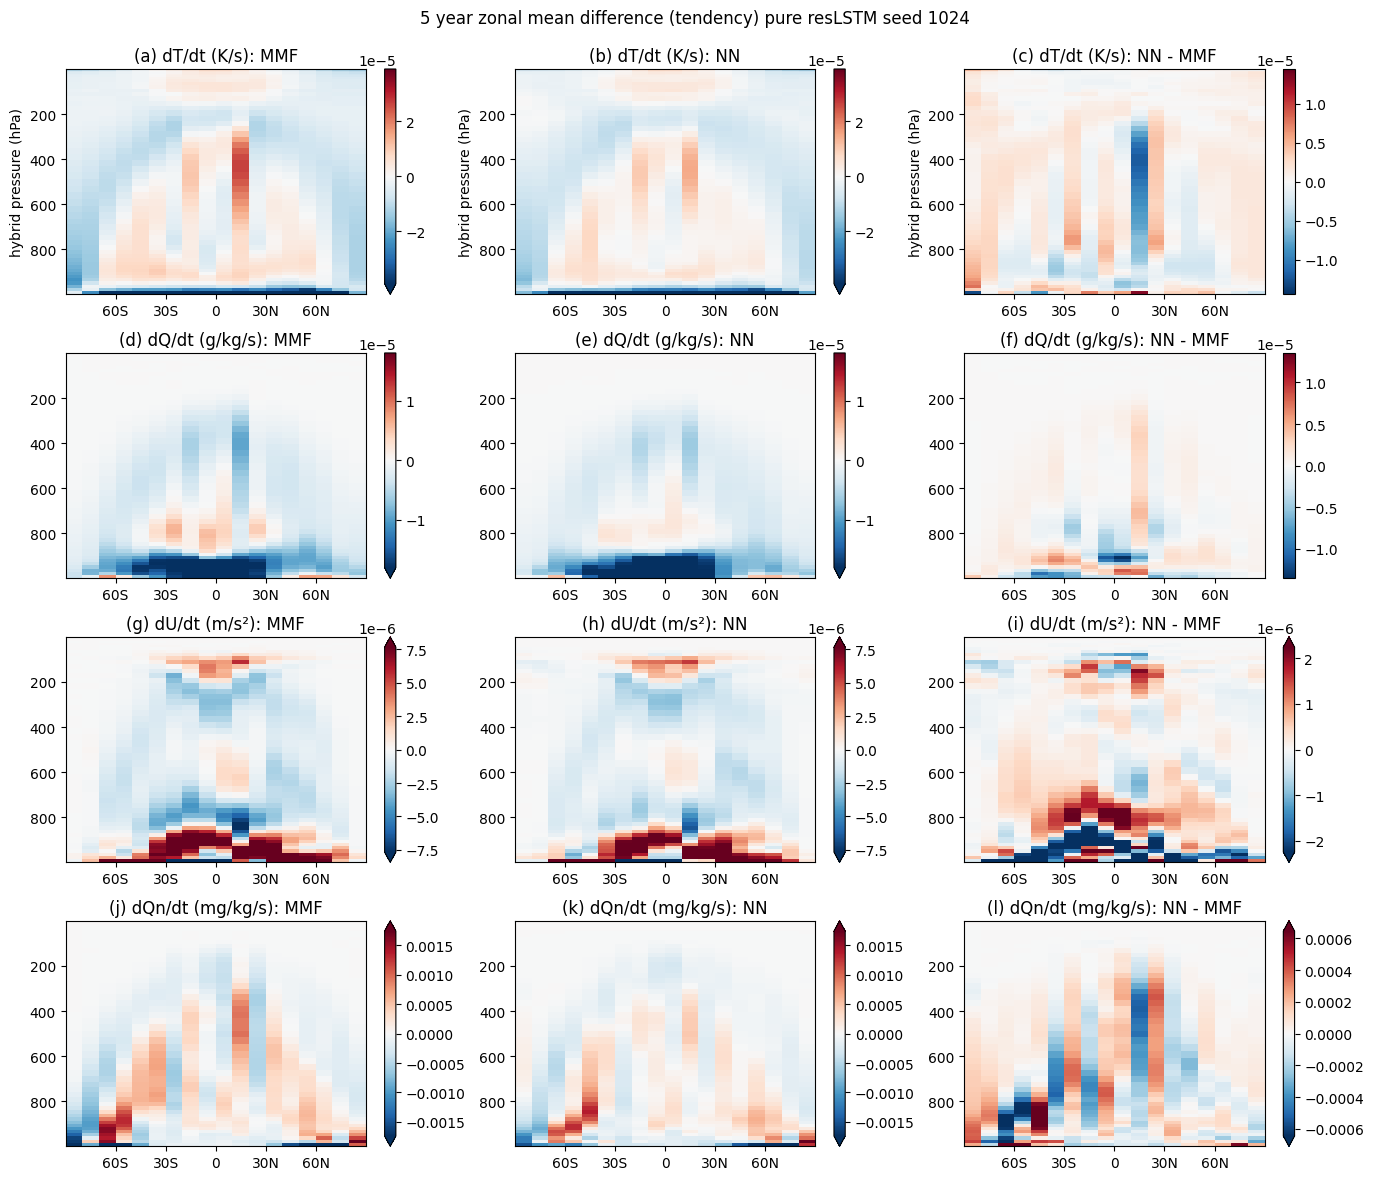

In [188]:
show_diff_tendency(ds_sp_1, ds_pure_resLSTM_seed_7, '(tendency) pure resLSTM seed 1024')

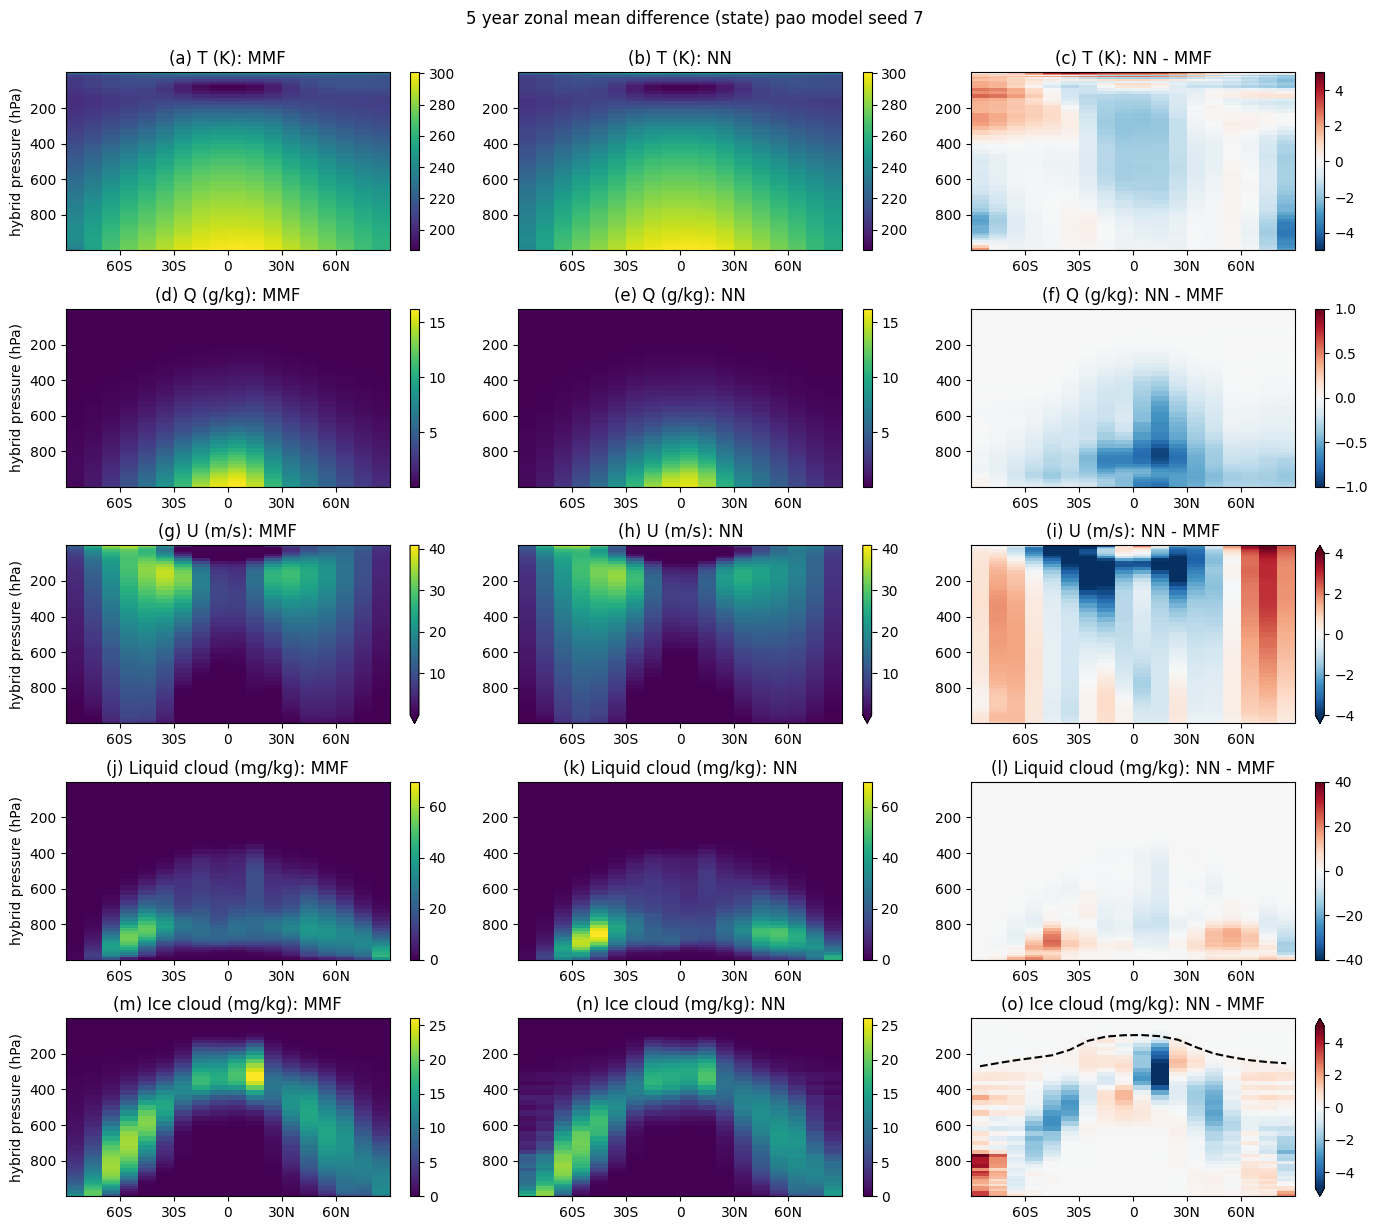

In [165]:
show_diff_state(ds_sp_1, ds_pao_model_seed_7, '(state) pao model seed 7')

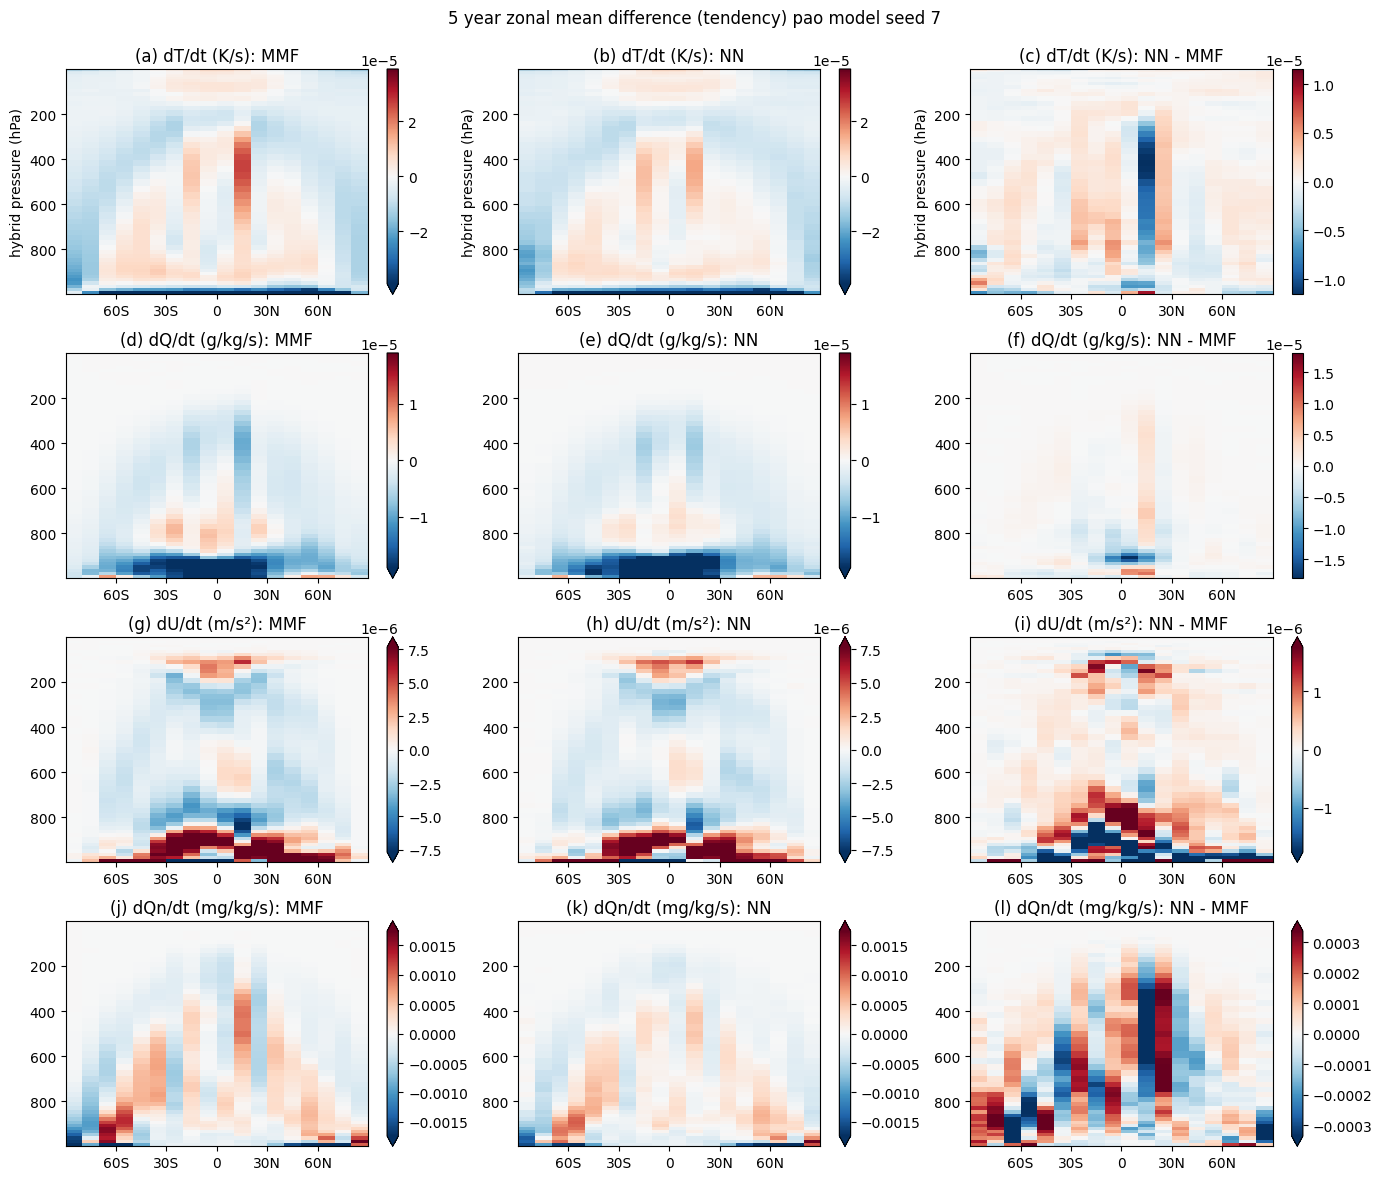

In [189]:
show_diff_tendency(ds_sp_1, ds_pao_model_seed_7, '(tendency) pao model seed 7')

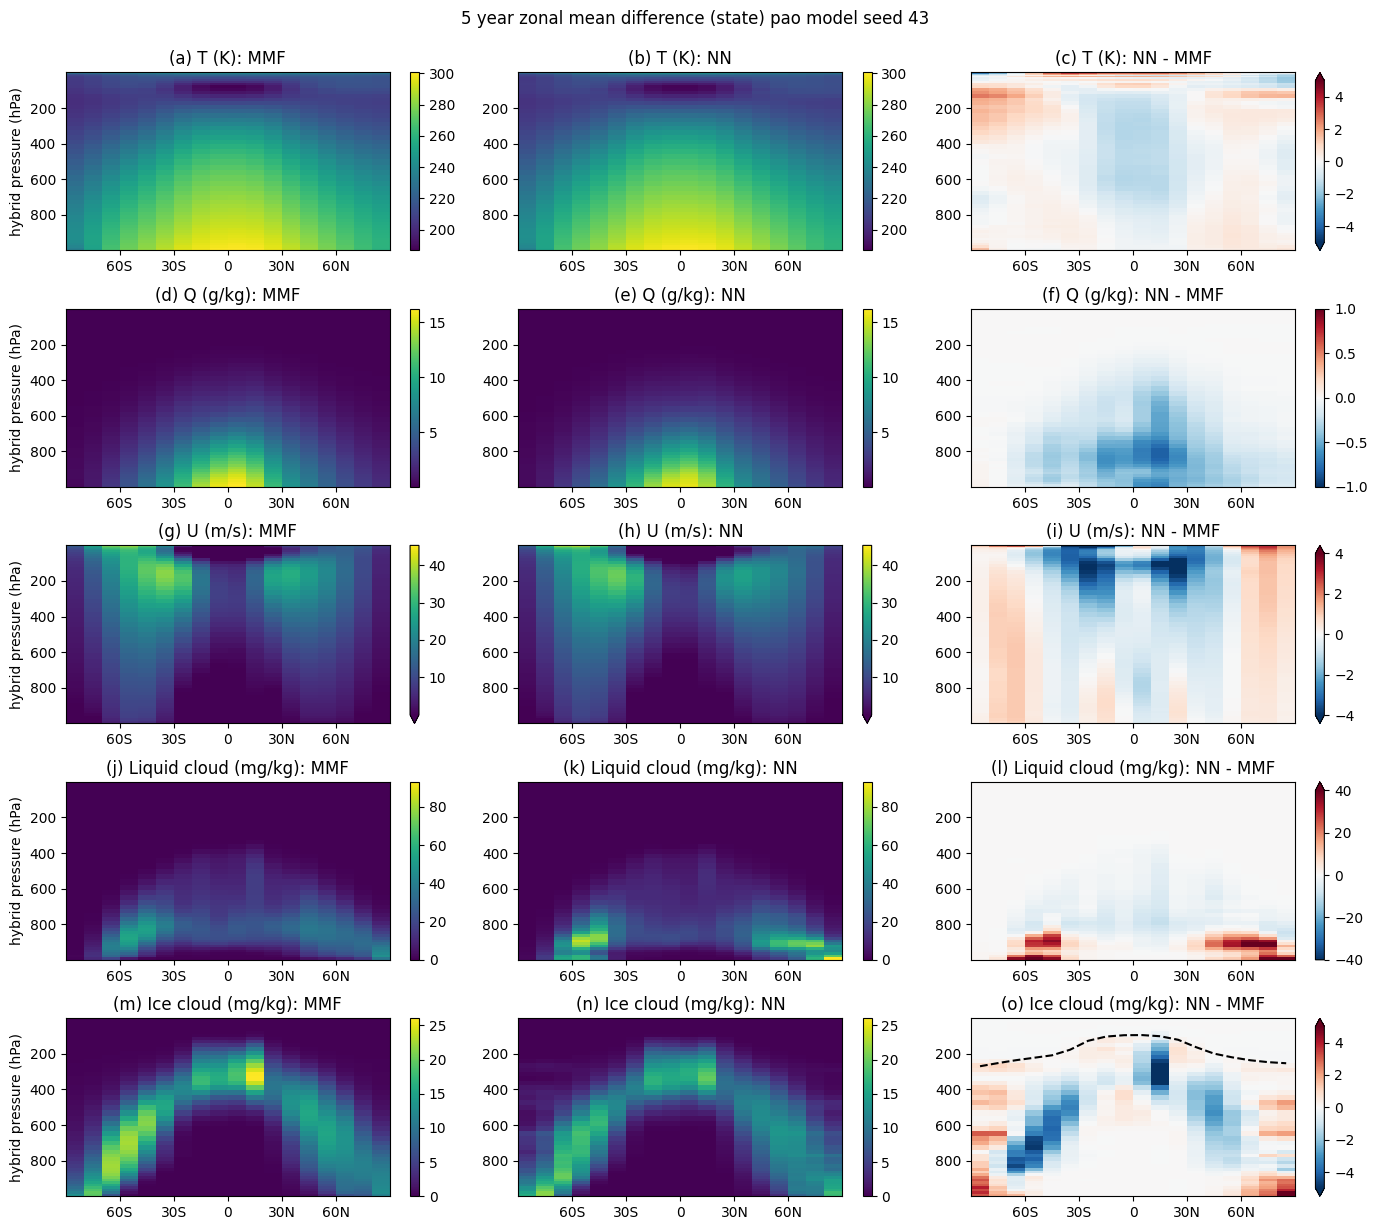

In [167]:
show_diff_state(ds_sp_1, ds_pao_model_seed_43, '(state) pao model seed 43')

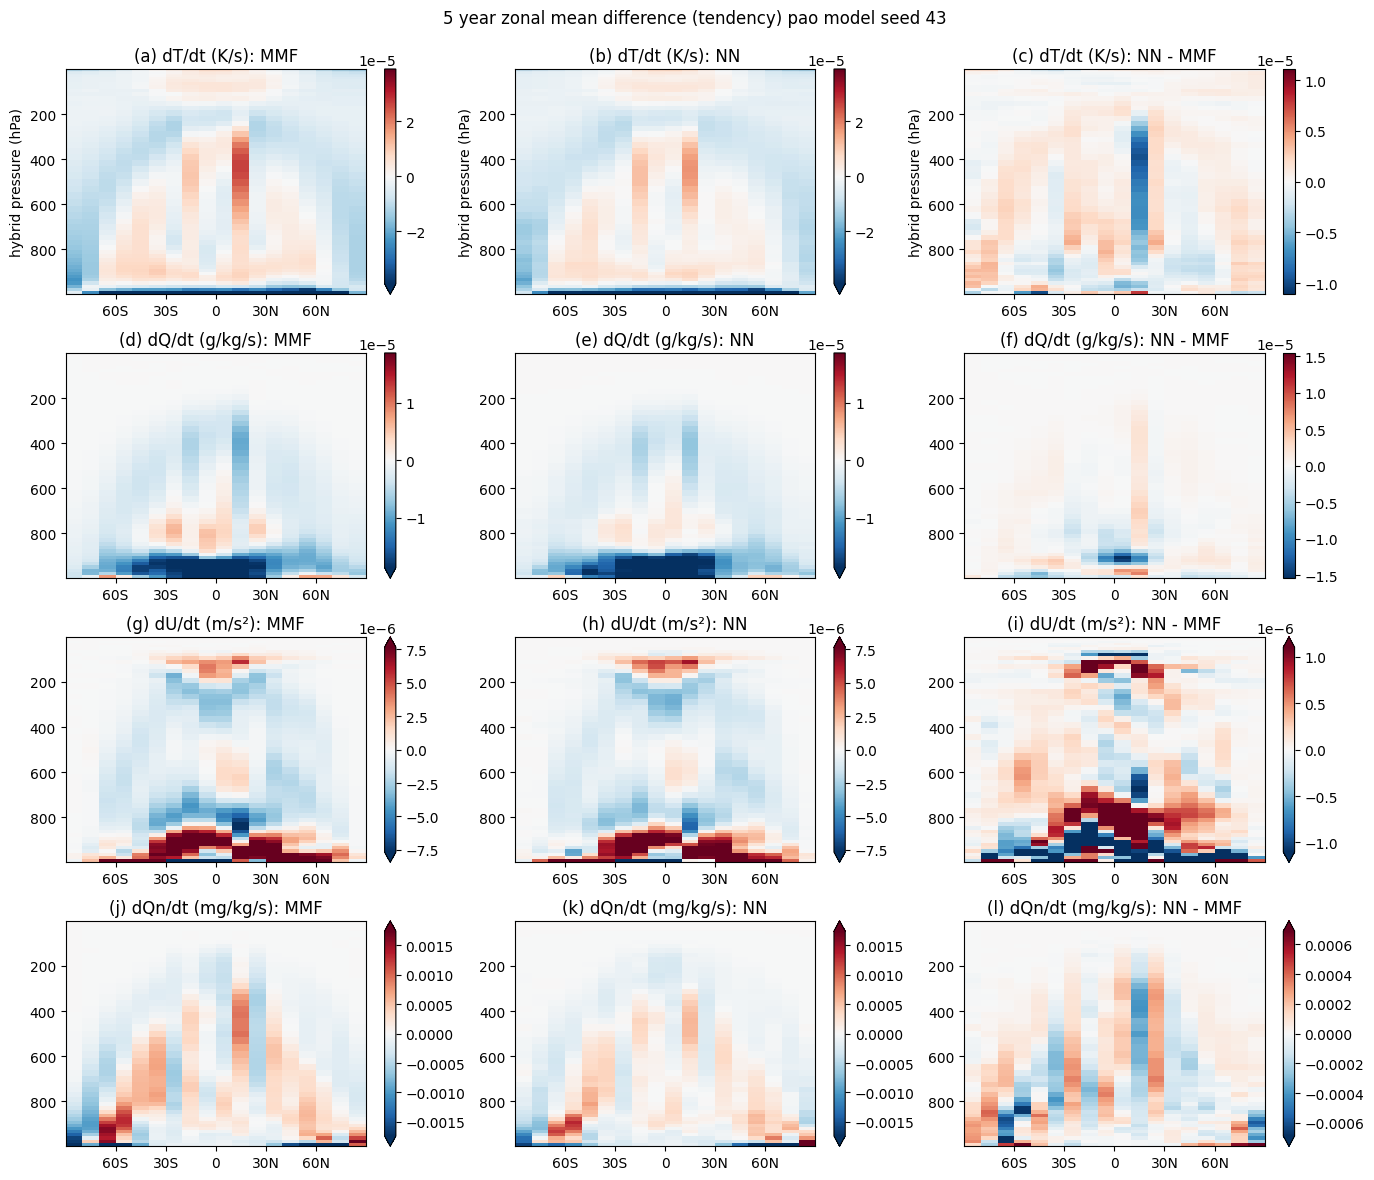

In [190]:
show_diff_tendency(ds_sp_1, ds_pao_model_seed_43, '(tendency) pao model seed 43')

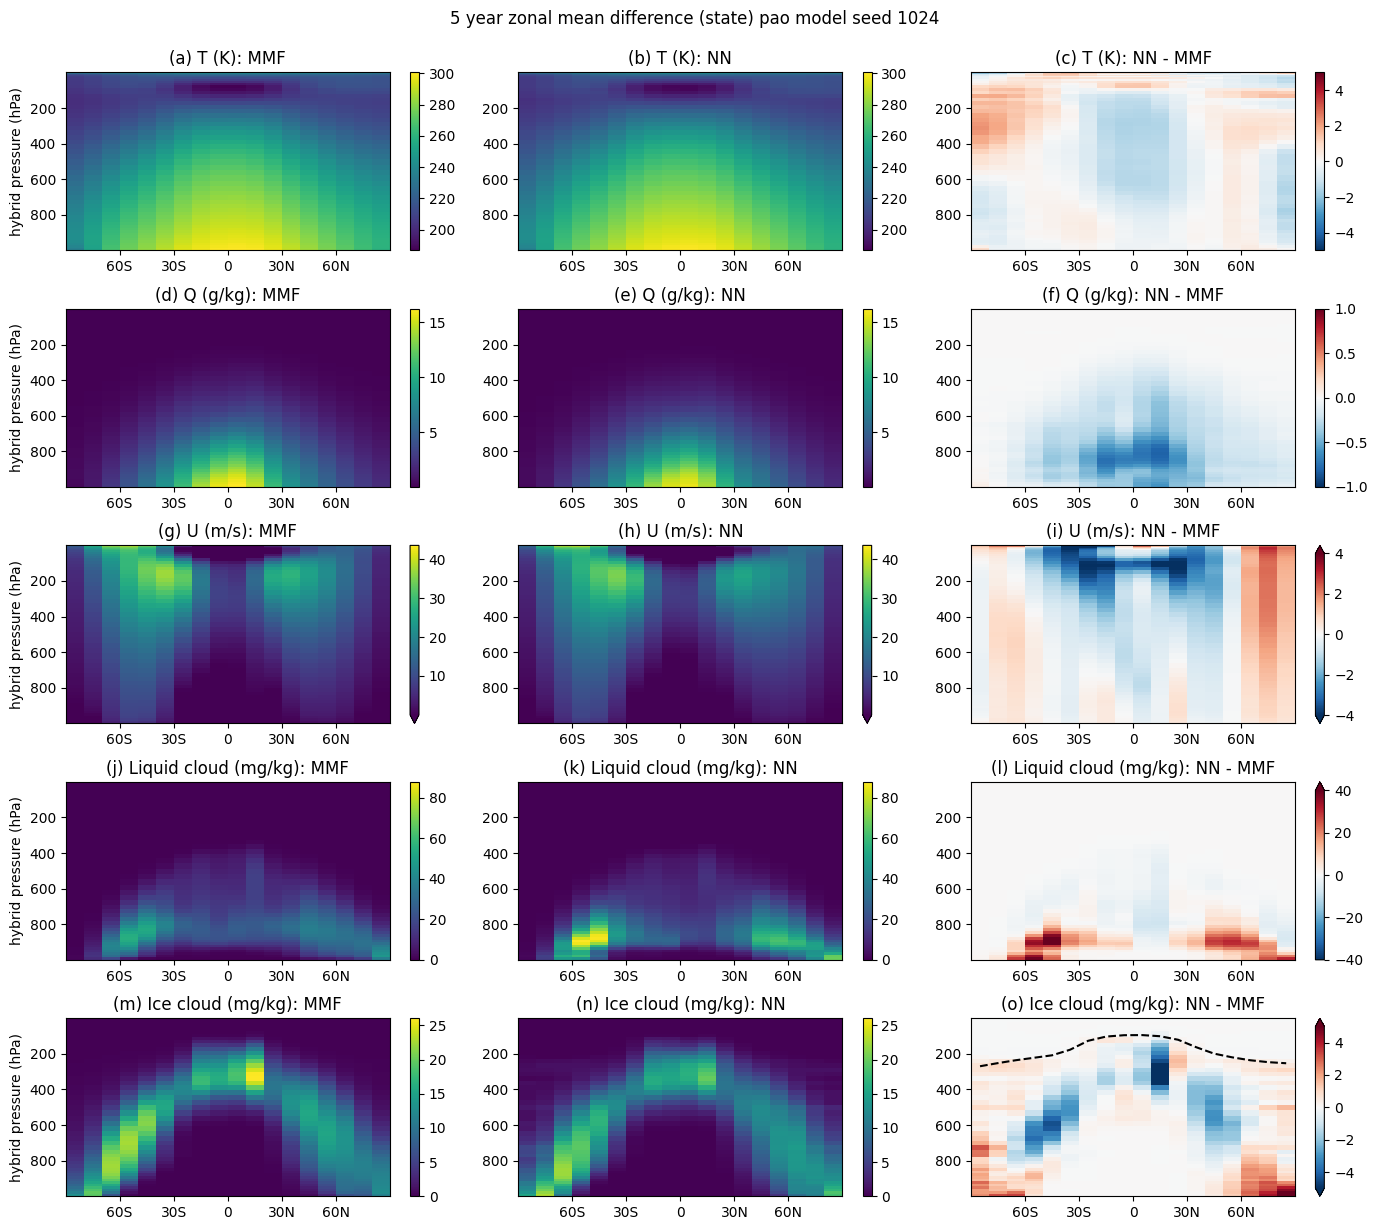

In [169]:
show_diff_state(ds_sp_1, ds_pao_model_seed_1024, '(state) pao model seed 1024')

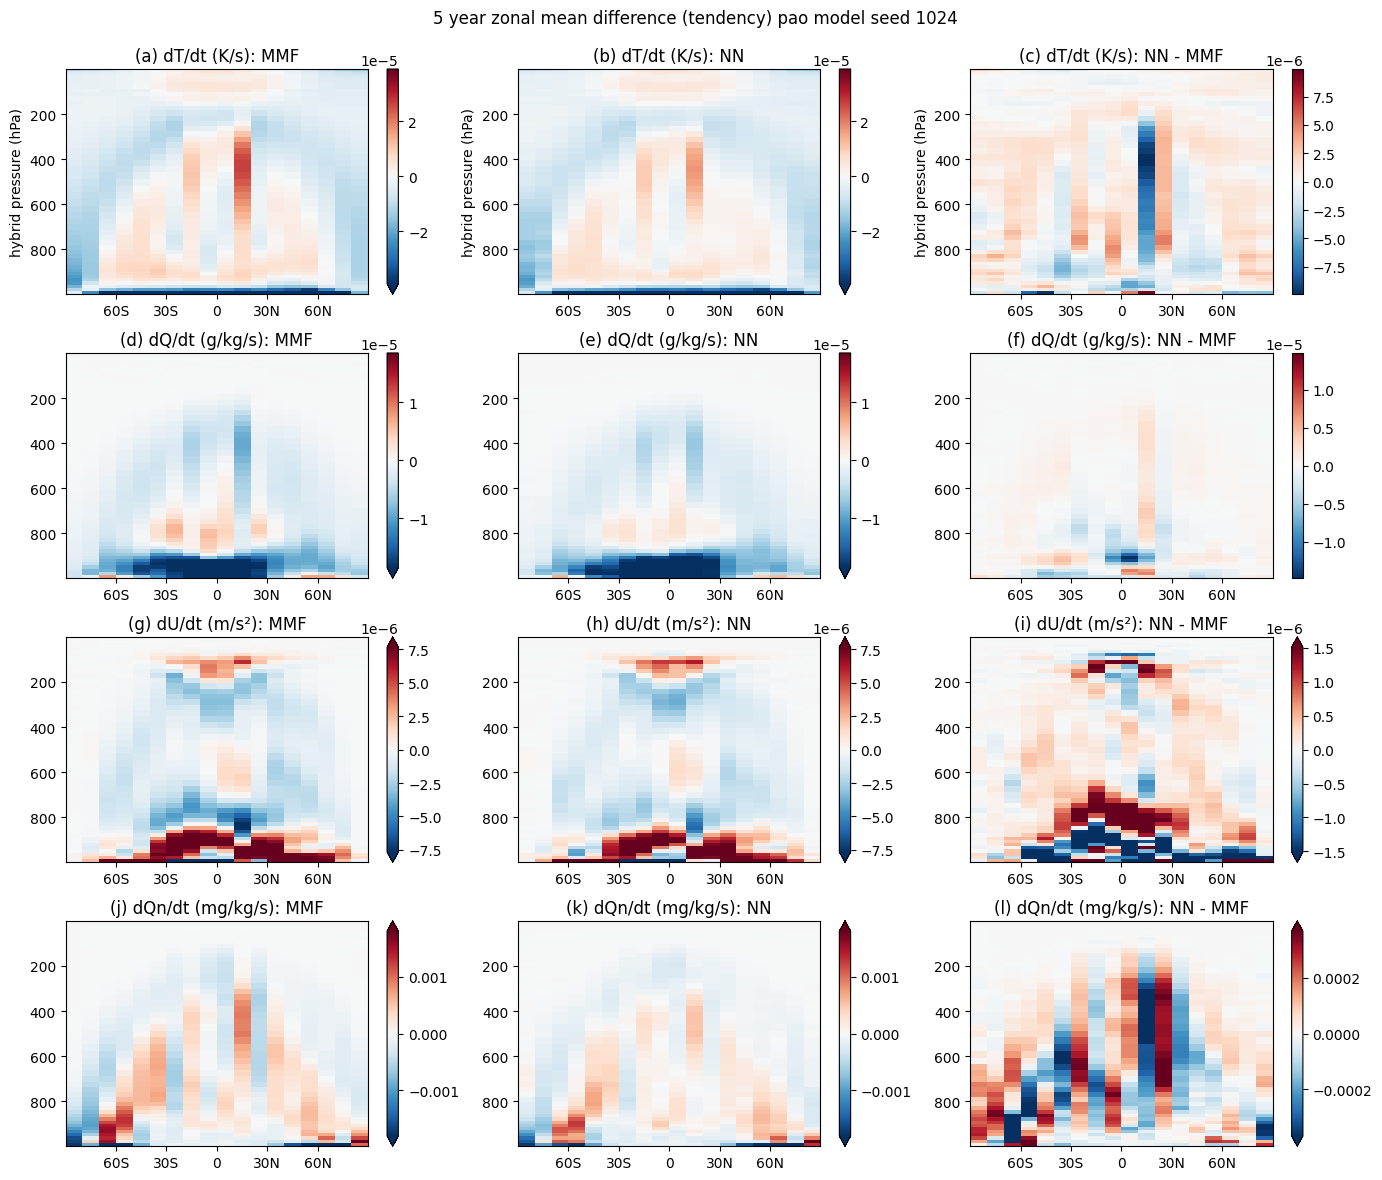

In [191]:
show_diff_tendency(ds_sp_1, ds_pao_model_seed_1024, '(tendency) pao model seed 1024')

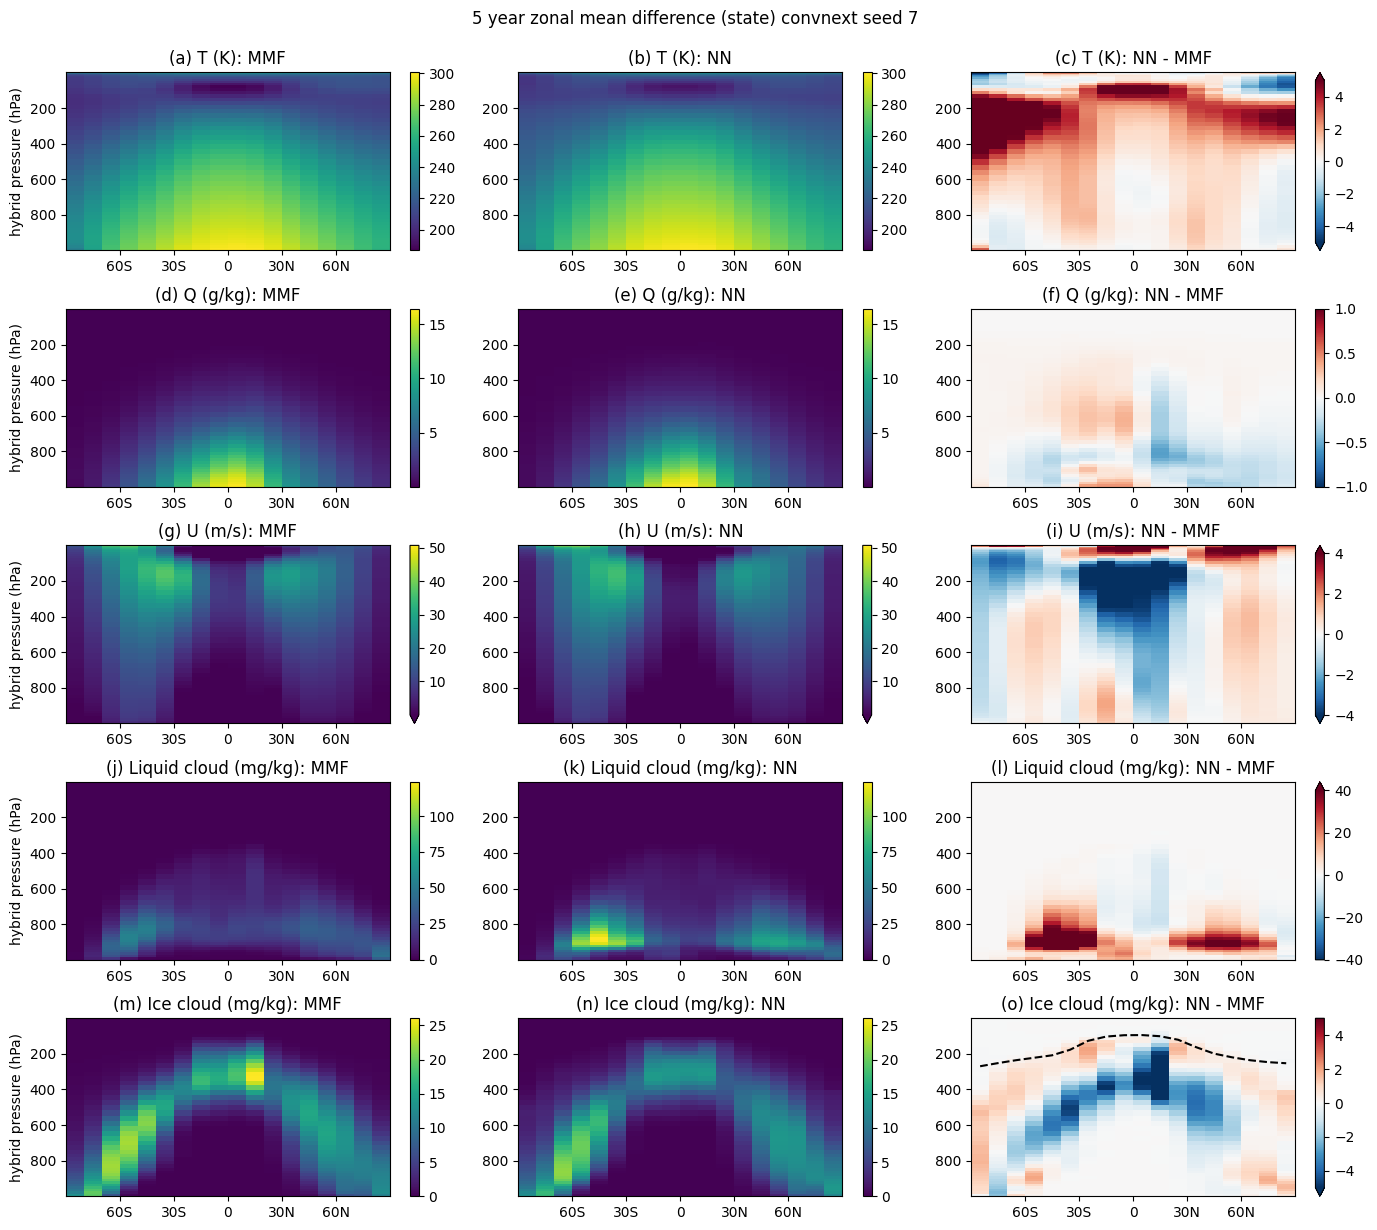

In [171]:
show_diff_state(ds_sp_1, ds_convnext_seed_7, '(state) convnext seed 7')

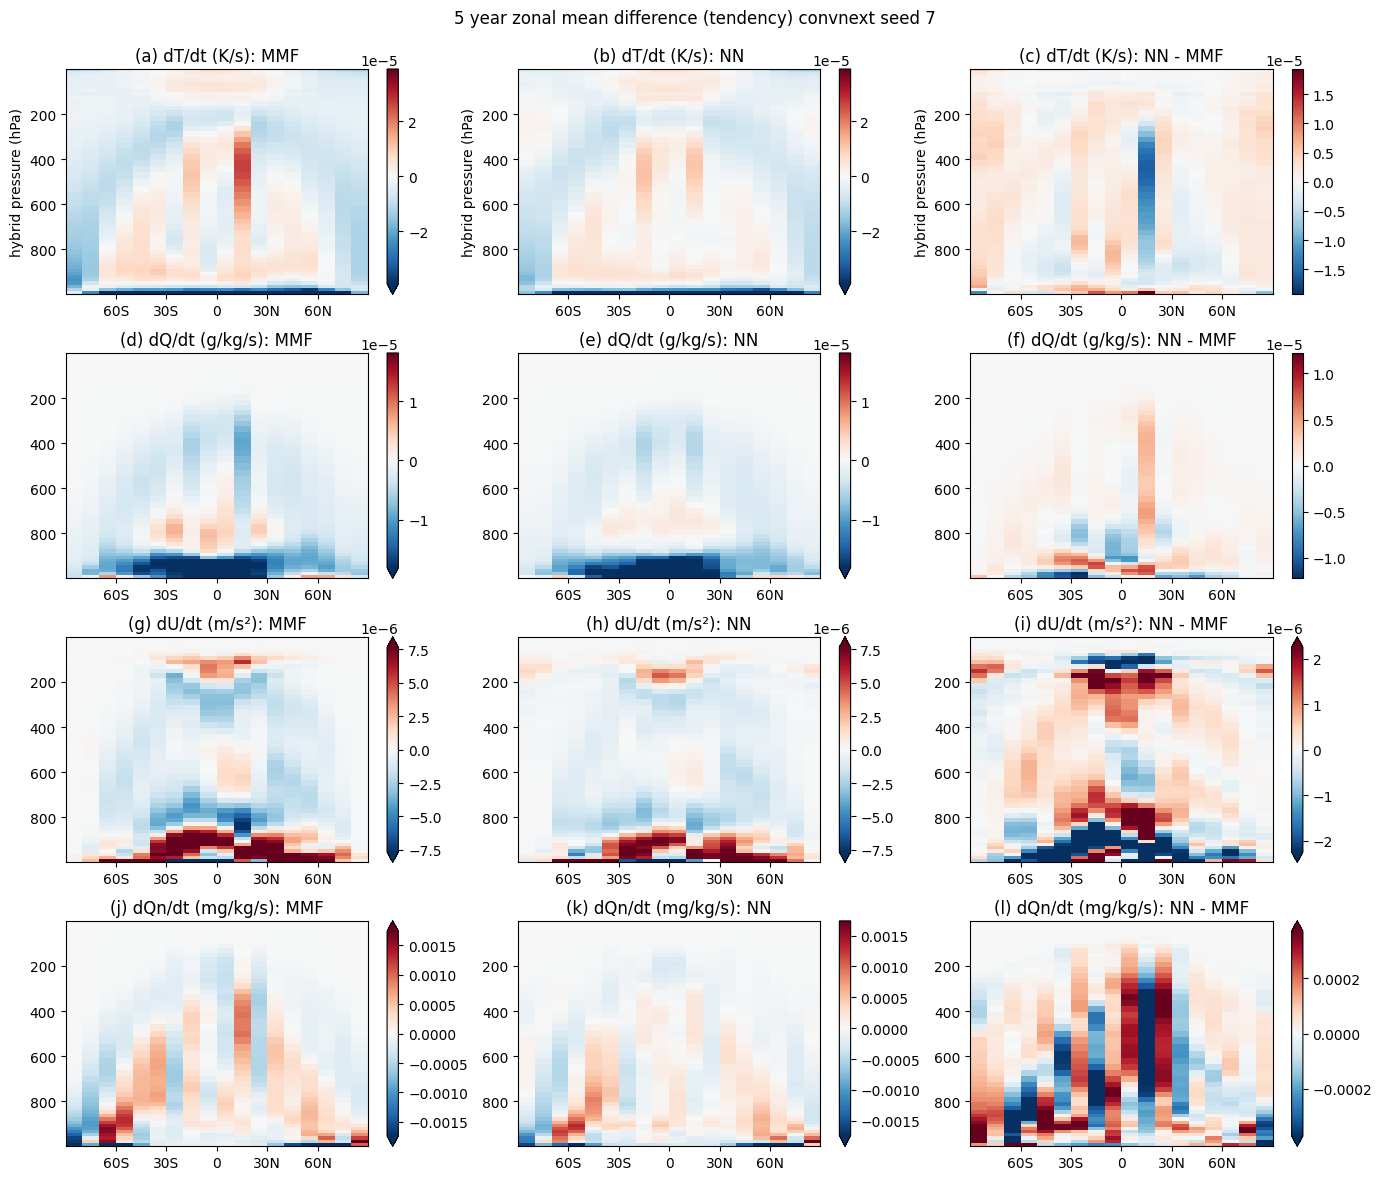

In [192]:
show_diff_tendency(ds_sp_1, ds_convnext_seed_7, '(tendency) convnext seed 7')

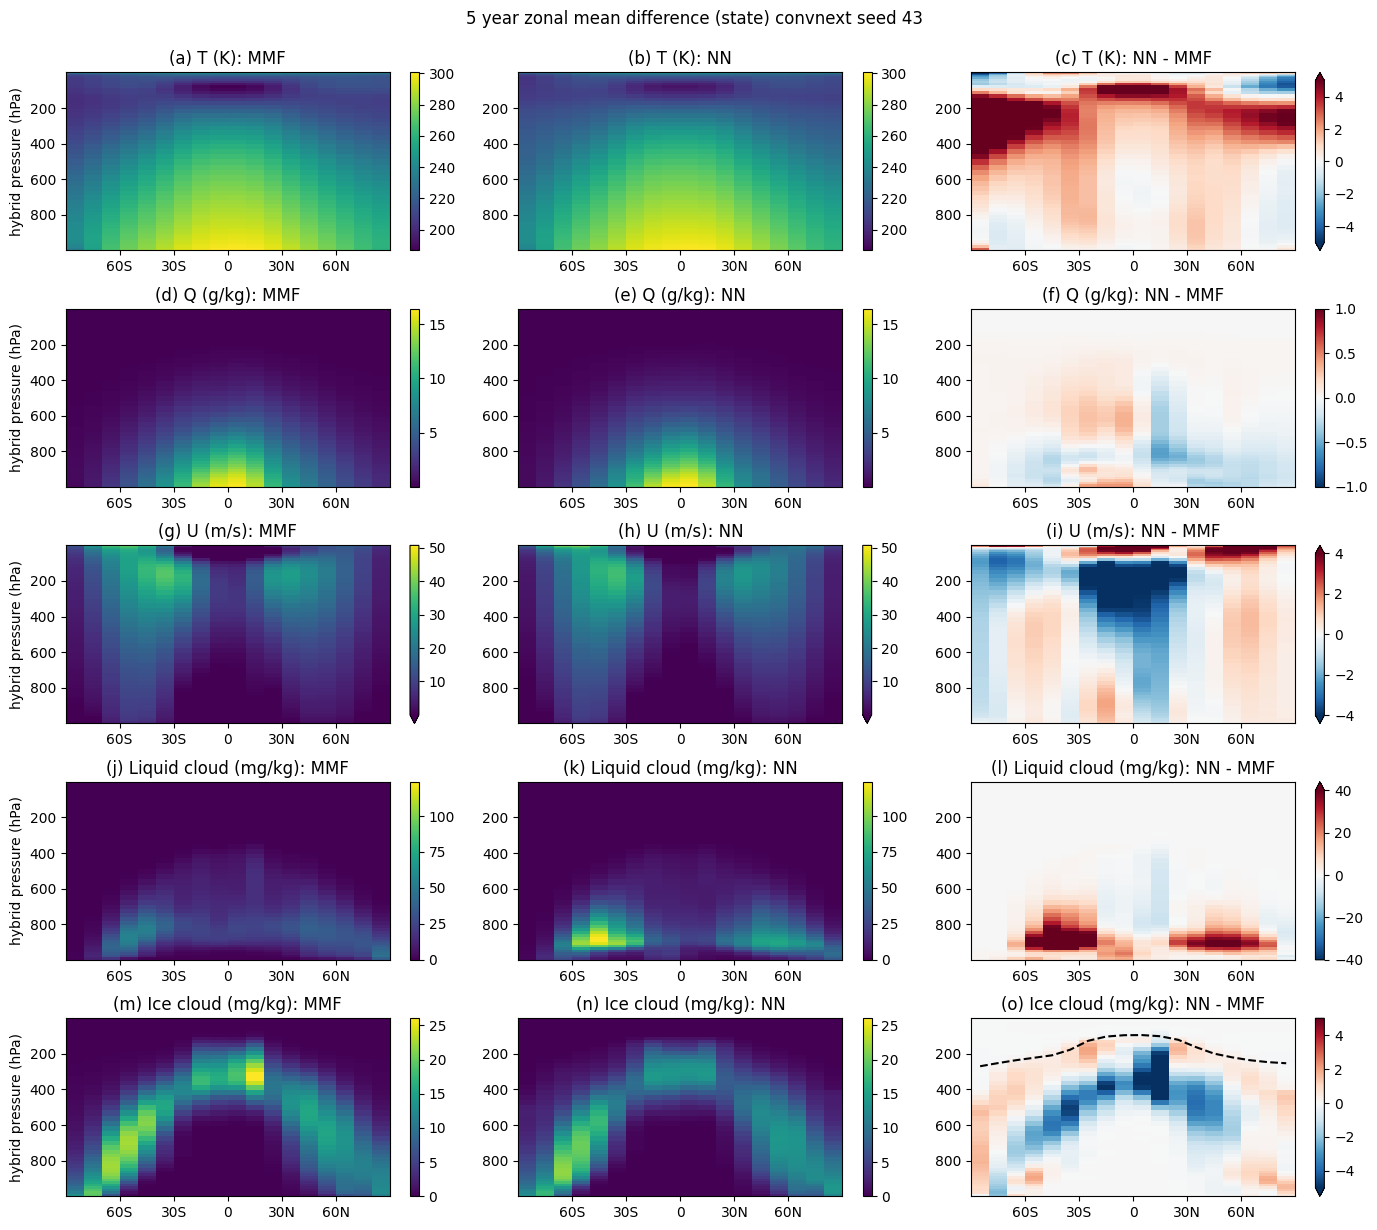

In [173]:
show_diff_state(ds_sp_1, ds_convnext_seed_7, '(state) convnext seed 43')

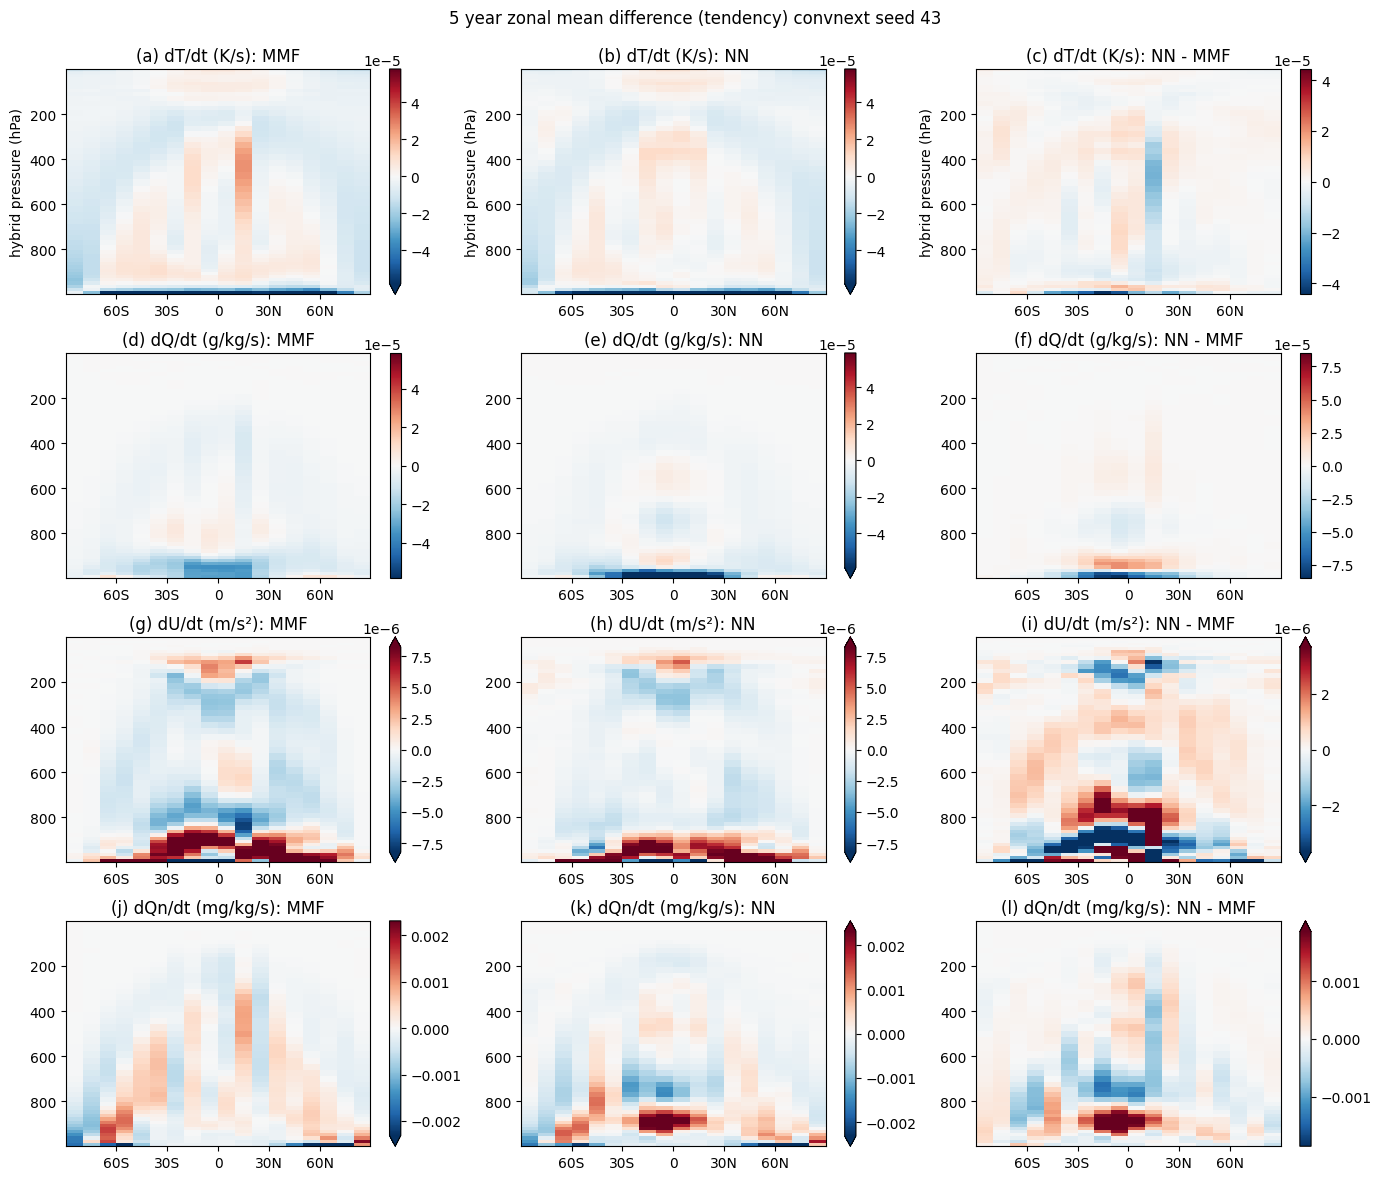

In [193]:
show_diff_tendency(ds_sp_1, ds_convnext_seed_43, '(tendency) convnext seed 43')

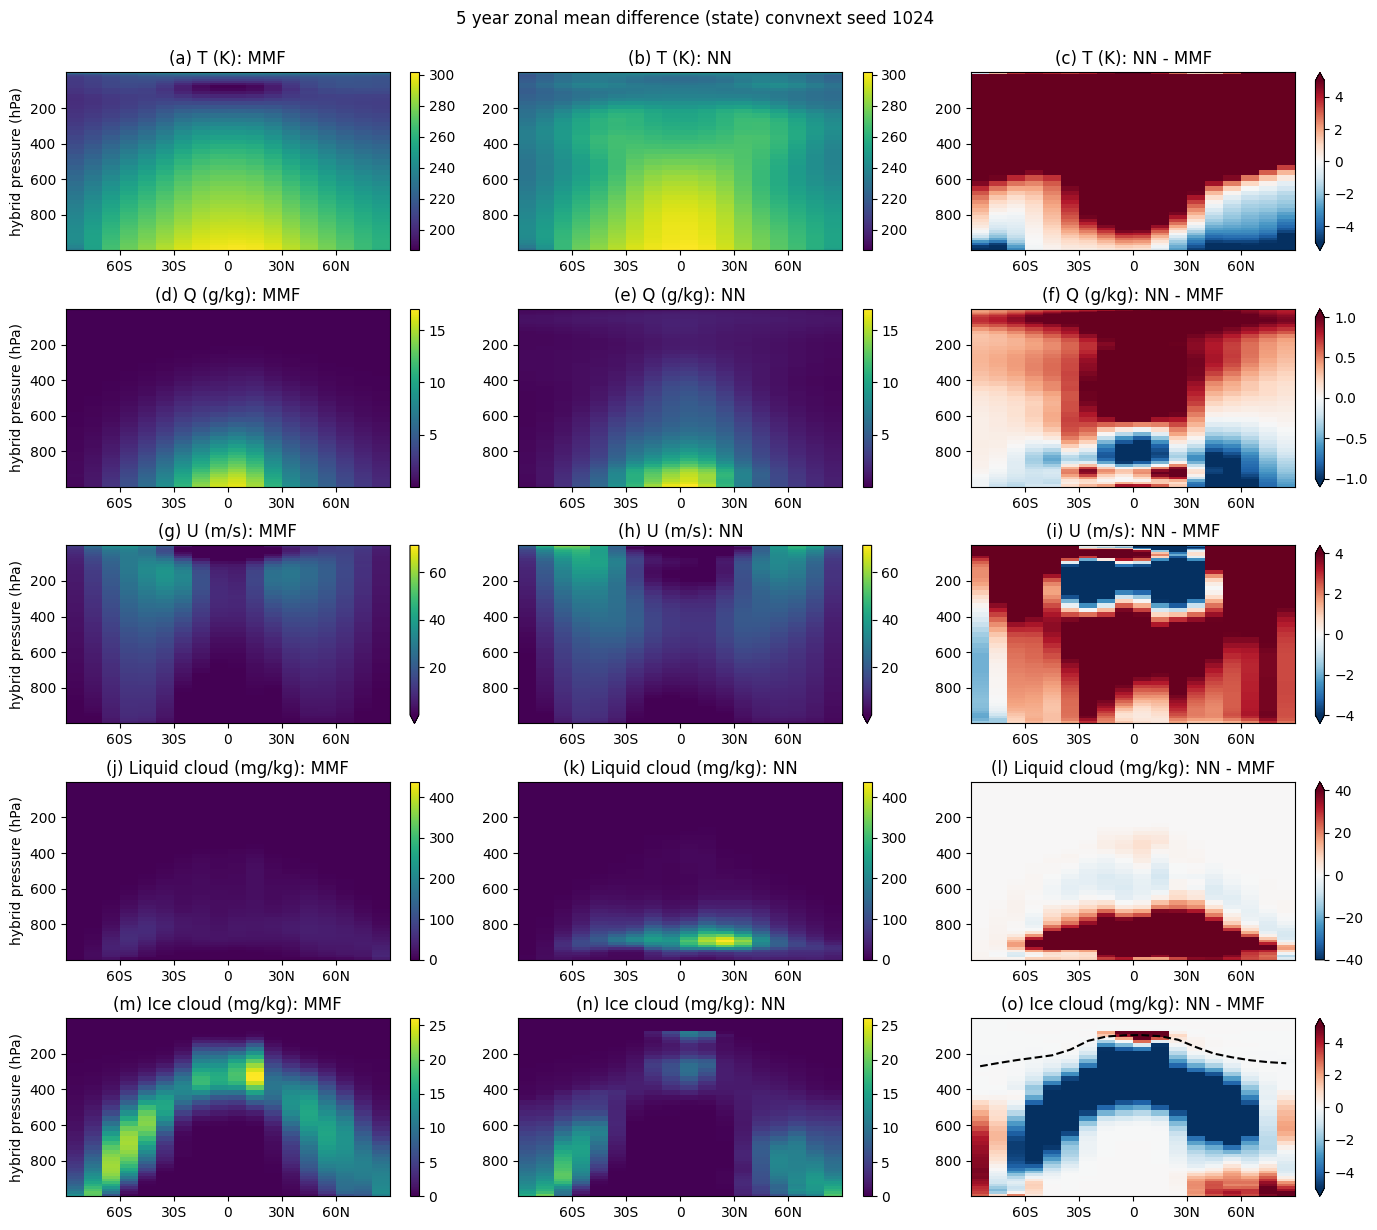

In [175]:
show_diff_state(ds_sp_1, ds_convnext_seed_1024, '(state) convnext seed 1024')

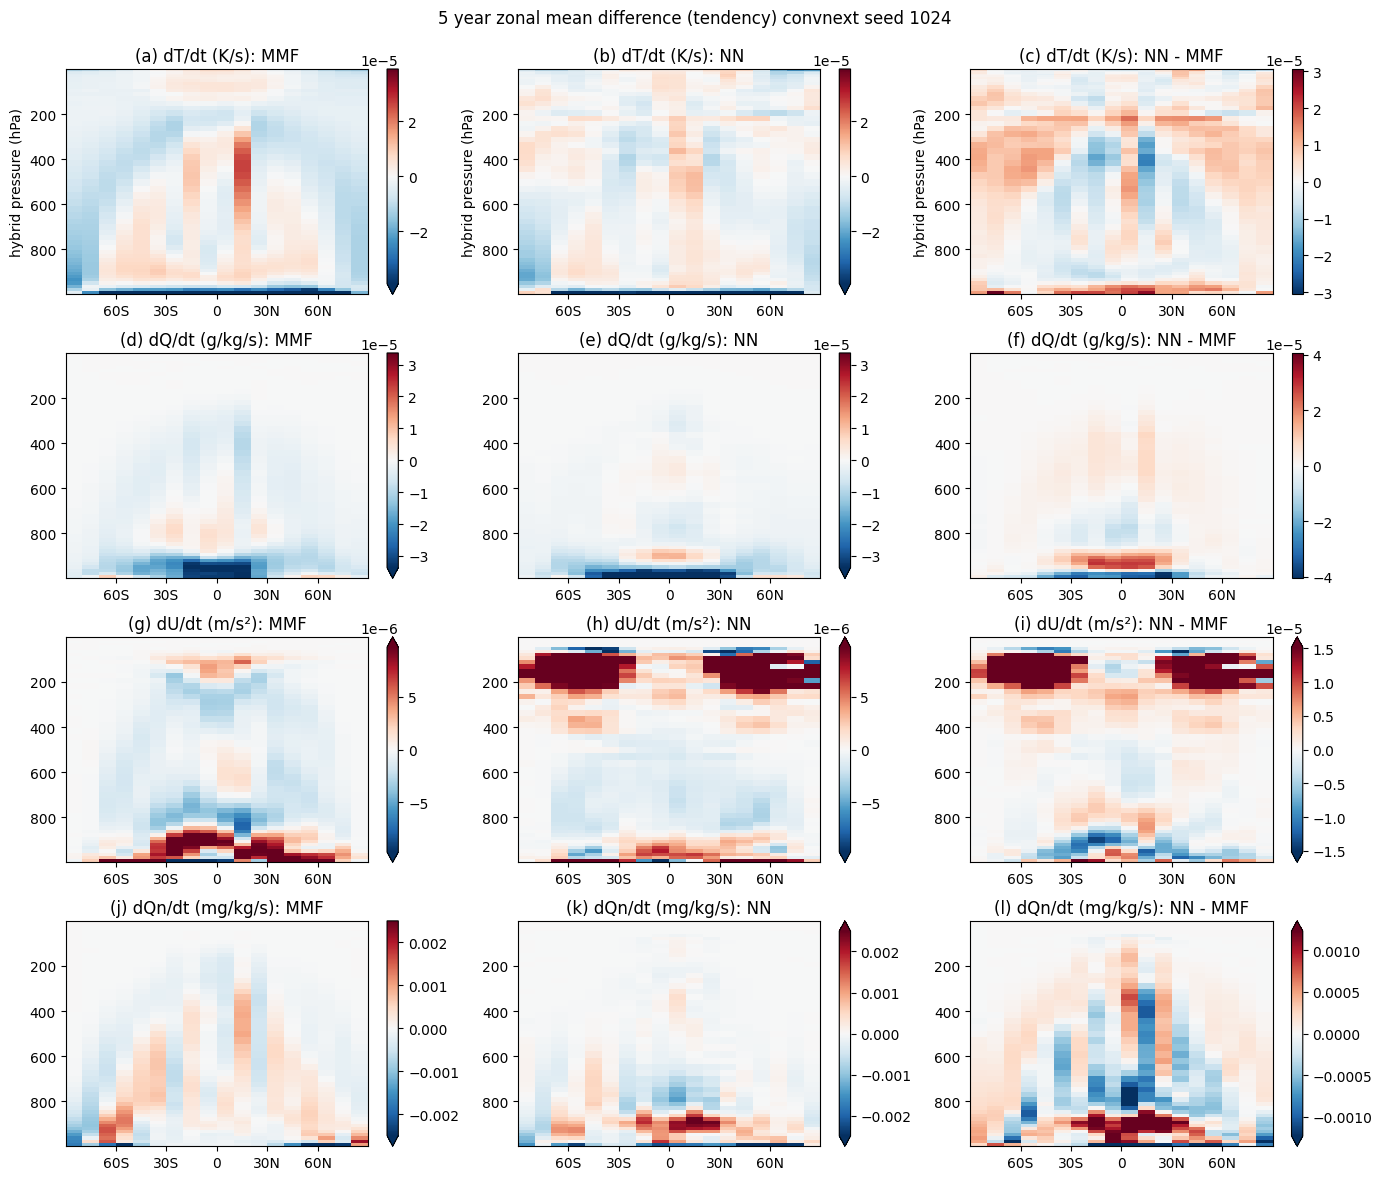

In [194]:
show_diff_tendency(ds_sp_1, ds_convnext_seed_1024, '(tendency) convnext seed 1024')

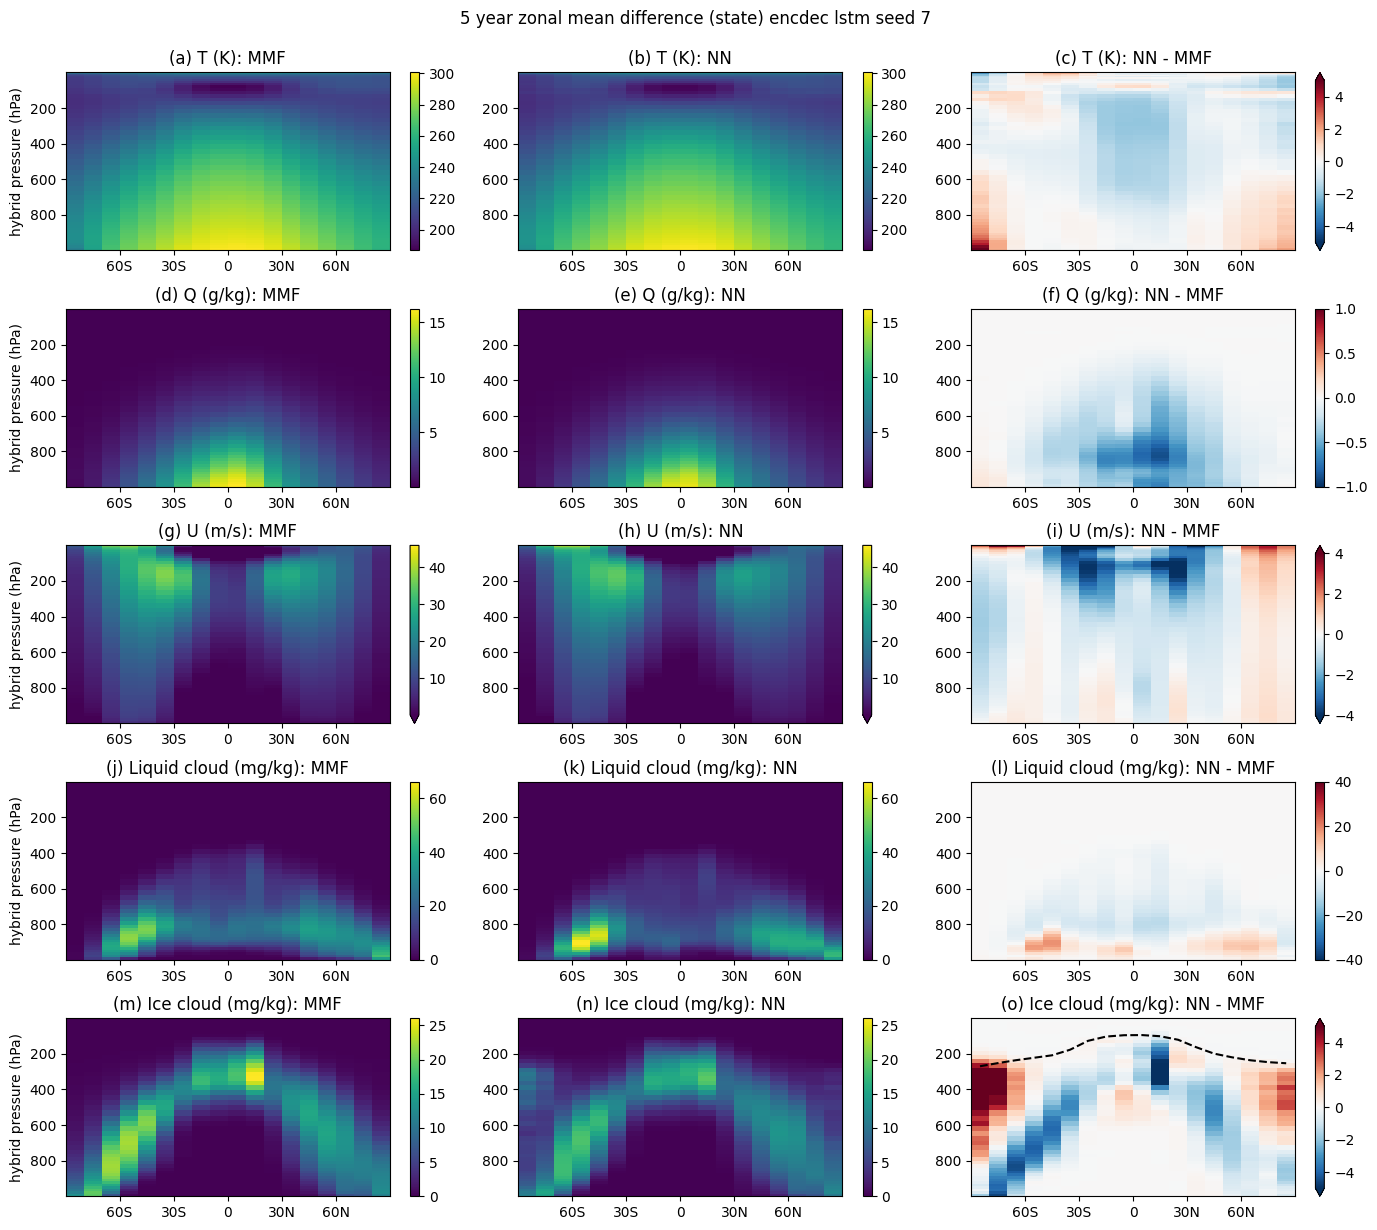

In [177]:
show_diff_state(ds_sp_1, ds_encdec_lstm_seed_7, '(state) encdec lstm seed 7')

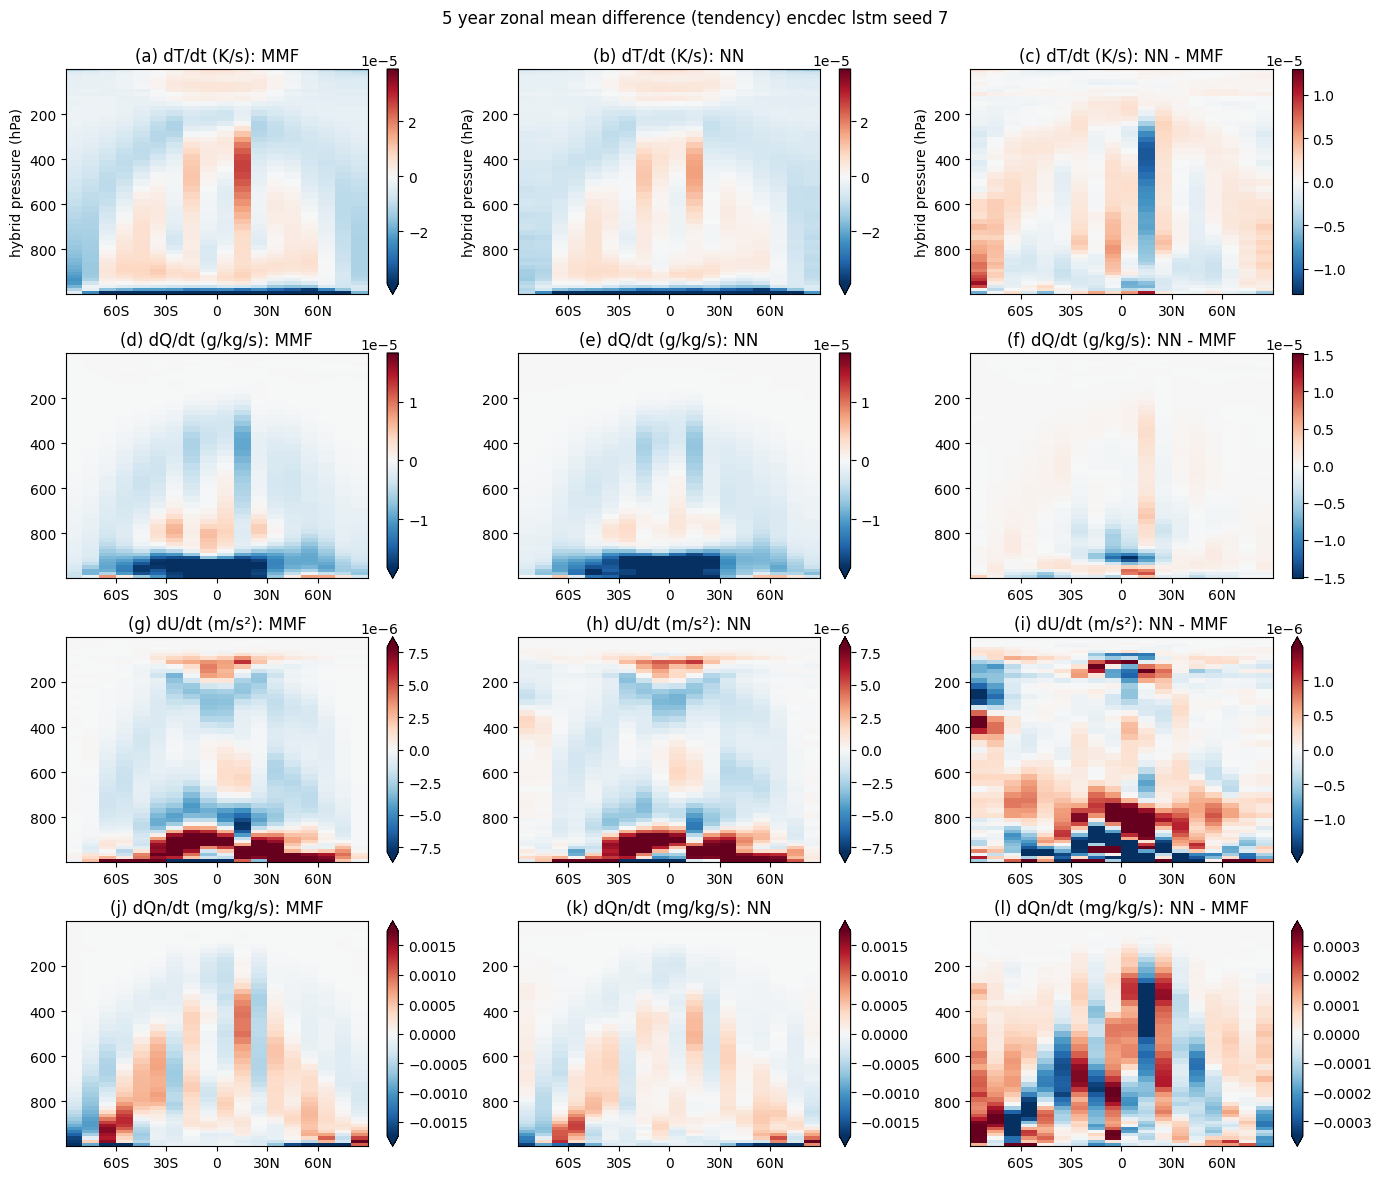

In [195]:
show_diff_tendency(ds_sp_1, ds_encdec_lstm_seed_7, '(tendency) encdec lstm seed 7')

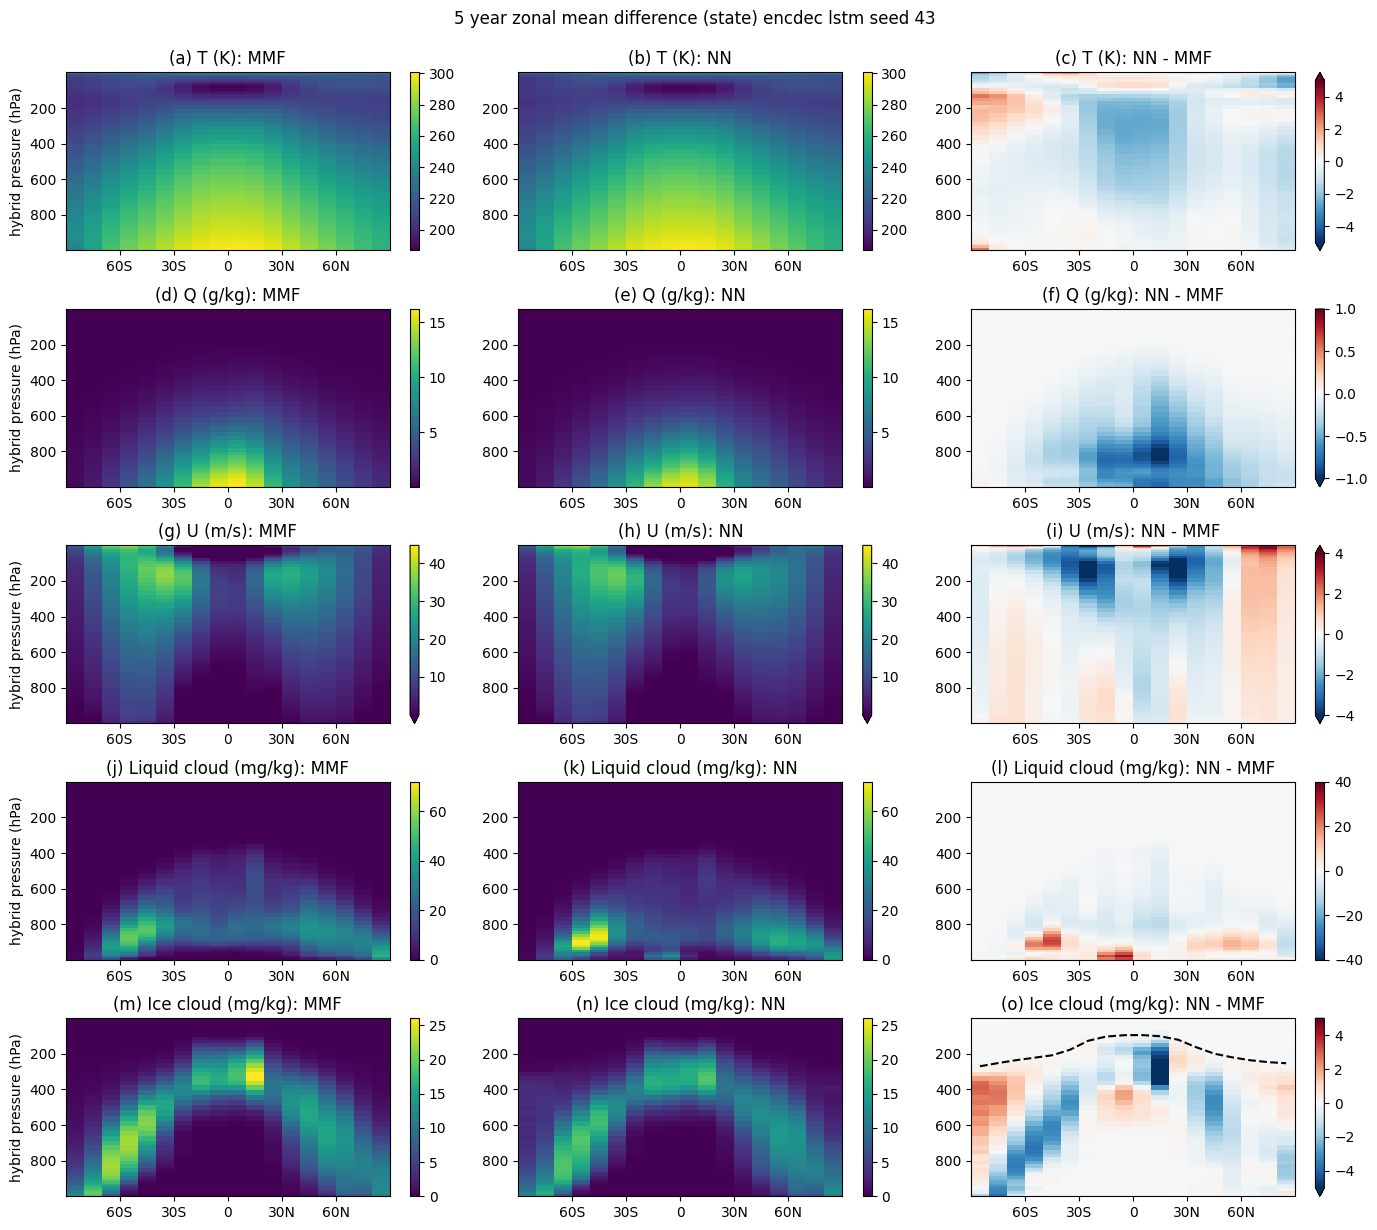

In [179]:
show_diff_state(ds_sp_1, ds_encdec_lstm_seed_43, '(state) encdec lstm seed 43')

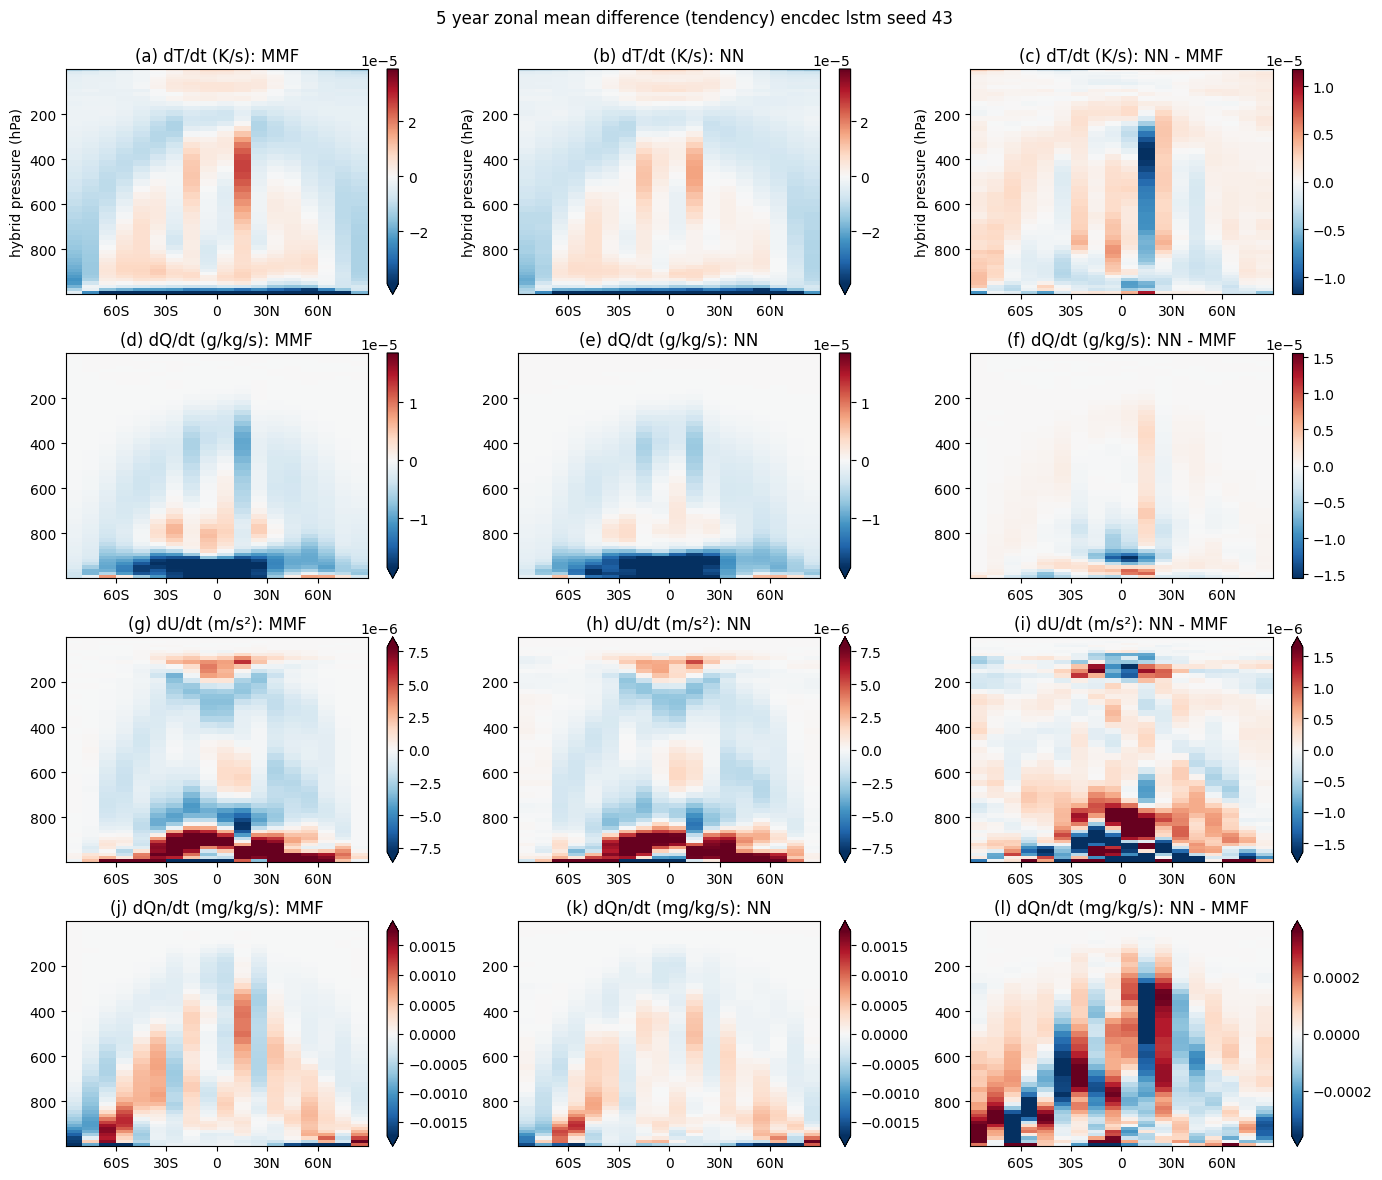

In [196]:
show_diff_tendency(ds_sp_1, ds_encdec_lstm_seed_43, '(tendency) encdec lstm seed 43')

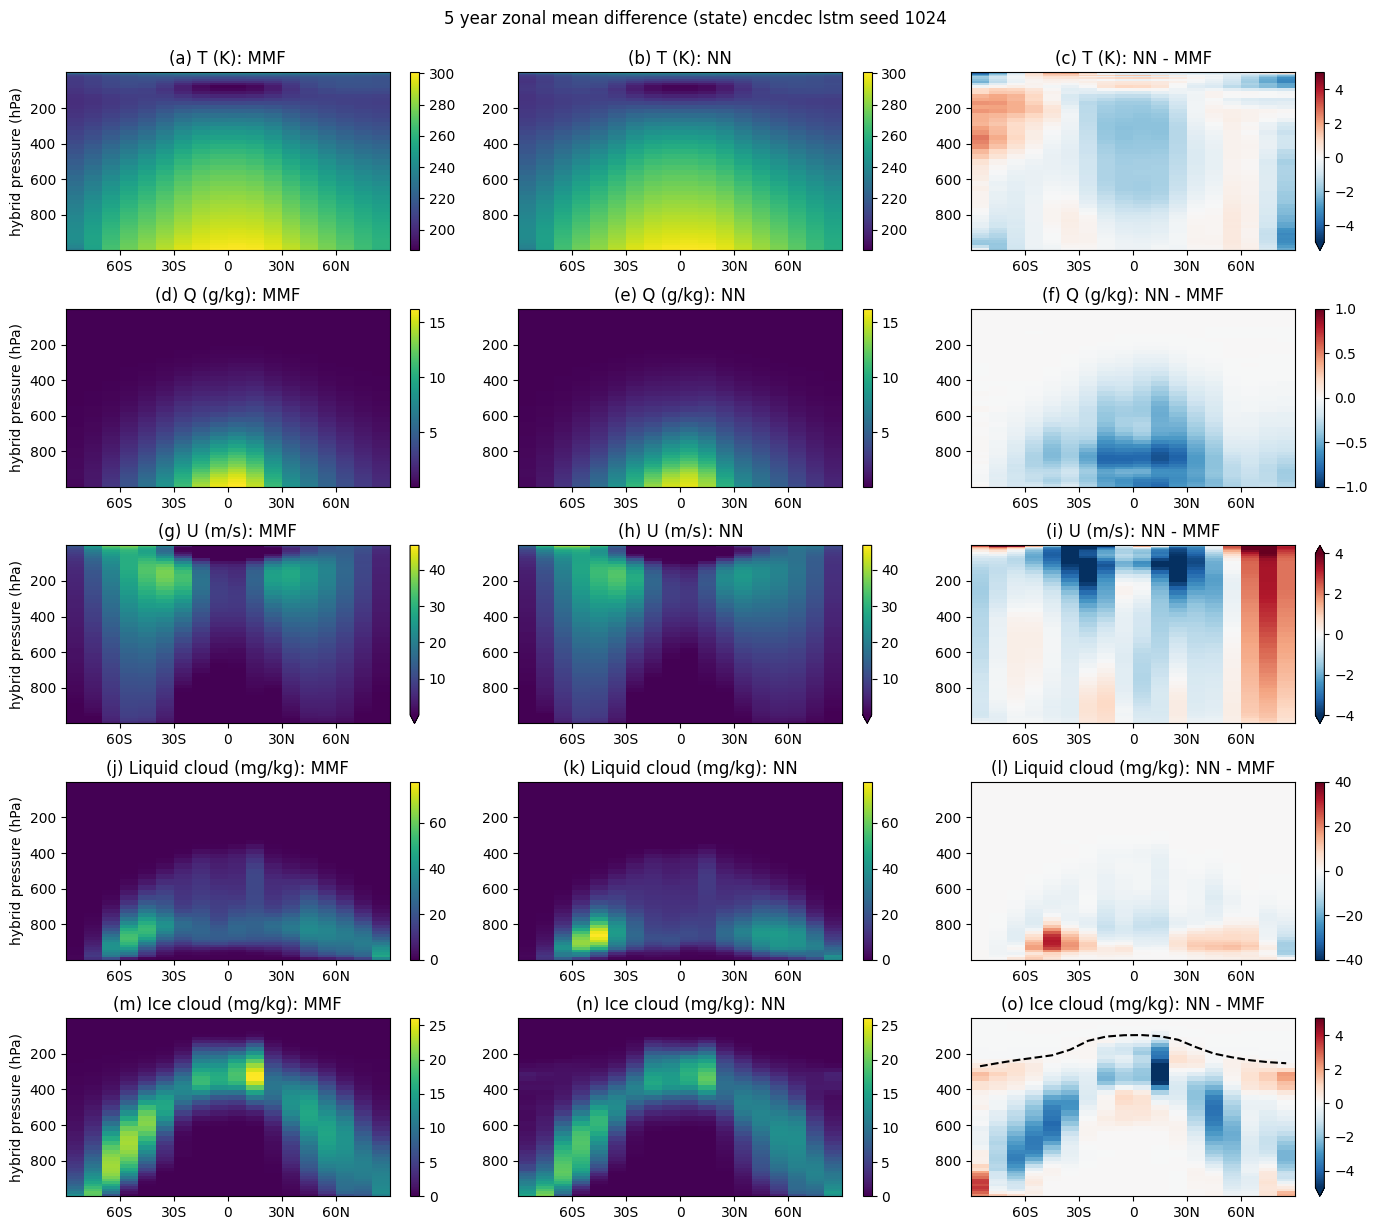

In [181]:
show_diff_state(ds_sp_1, ds_encdec_lstm_seed_1024, '(state) encdec lstm seed 1024')

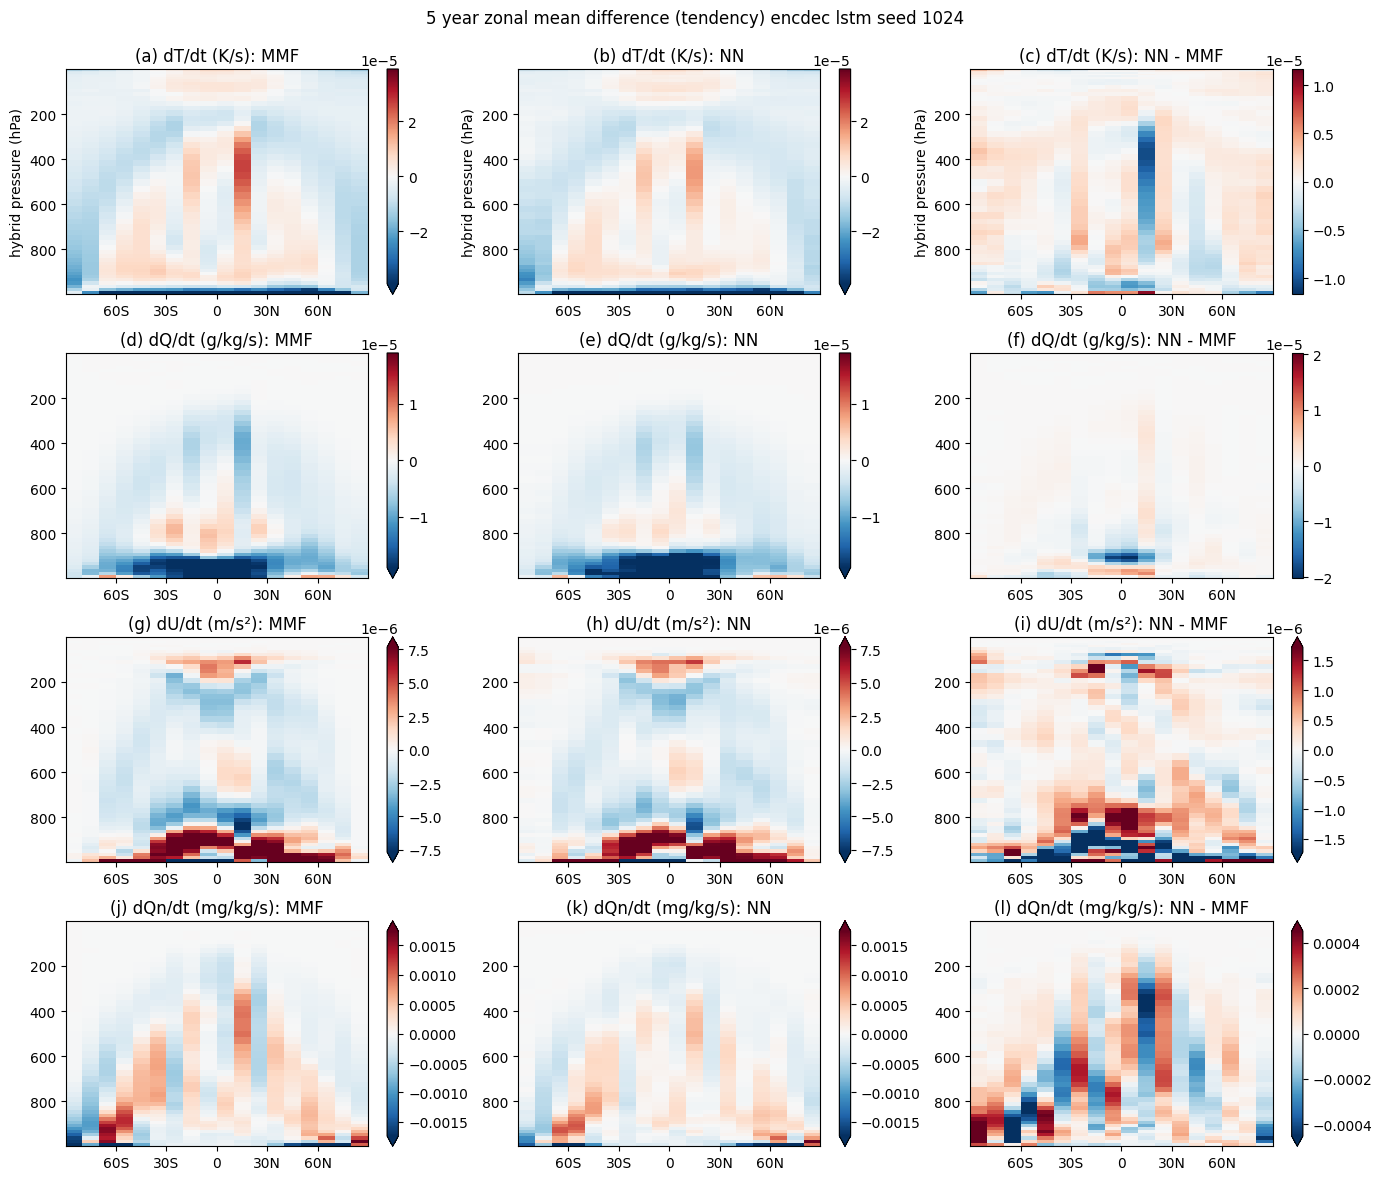

In [197]:
show_diff_tendency(ds_sp_1, ds_encdec_lstm_seed_1024, '(tendency) encdec lstm seed 1024')

In [27]:
# retrieve precomputed 1-year tropopause level distribution (we used as a microphysics constraint)
idx_p400_t10 = np.load('/pscratch/sd/z/zeyuanhu/hu_etal2024_data/microphysics_hourly/first_true_indices_p400_t10.npy')
for i in range(idx_p400_t10.shape[0]):
    for j in range(idx_p400_t10.shape[1]):
        idx_p400_t10[i,j] = level[int(idx_p400_t10[i,j])]

idx_p400_t10 = idx_p400_t10.mean(axis=0)
idx_p400_t10 = idx_p400_t10[:,np.newaxis]

idx_tropopause_zm = data.zonal_bin_weight_2d(idx_p400_t10.transpose())

(384,)

In [ ]:
xtime = np.arange(60)

area_weight_nh = np.where(lat > 30, area_weight, 0)
area_weight_sh = np.where(lat < -30, area_weight, 0)
area_weight_tropics = np.where((lat > - 30) & (lat < 30), area_weight, 0)

# Titles for columns
column_titles = ['Global mean', '30N-90N mean', '30S-90S mean', '30S-30N mean']

# Y-axis labels for rows
row_ylabels = [
    'T$_{59}$ (K)',
    'Precipitable water (kg/m$^2$)',
    'Total cloud path (kg/m$^2$)'
]

# Define area weights
weights = ['area_weight', 'area_weight_nh', 'area_weight_sh', 'area_weight_tropics']
weights_dict = {
    'area_weight': area_weight,
    'area_weight_nh': area_weight_nh,
    'area_weight_sh': area_weight_sh,
    'area_weight_tropics': area_weight_tropics,
}

# Define variables and associated averaging functions
variables = ['T', 'TMQ', 'TCP']
get_mean_function = {
    'T': lambda ds, w: np.average(ds['T'][1:, -1, :].values, weights=w, axis=1),
    'TMQ': lambda ds, w: np.average(ds['TMQ'][1:, :].values, weights=w, axis=1),
    'TCP': lambda ds, w: get_tcp_mean(ds, w)
}

# Create a figure with 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(18, 8))

# Generate subplots
for row, var in enumerate(variables):
    for col, weight_key in enumerate(weights):
        weight = weights_dict[weight_key]
        mmf_mean = get_mean_function[var](ds_sp, weight)
        mmf2_mean = get_mean_function[var](ds_sp_2, weight)
        unet_mean = get_mean_function[var](ds_unet_v2_rh_mc, weight)
        squeezeformer_mean = get_mean_function[var](ds_squeezeformer_v2_rh_mc, weight)
        pure_resLSTM_mean = get_mean_function[var](ds_pure_resLSTM_v2_rh_mc, weight)
        pao_model_mean = get_mean_function[var](ds_pao_model_v2_rh_mc, weight)
        convnext_mean = get_mean_function[var](ds_convnext_v2_rh_mc, weight)
        encdec_lstm_mean = get_mean_function[var](ds_encdec_lstm_v2_rh_mc, weight)
        
        axes[row, col].plot(xtime, mmf_mean, label='MMF', color='black')
        axes[row, col].plot(xtime, mmf2_mean, label='MMF2', color='black', linestyle = 'dashed')
        axes[row, col].plot(xtime, unet_mean, label='unet', color='green', linestyle = 'dashed')
        axes[row, col].plot(xtime, squeezeformer_mean, label='squeezeformer', color='purple', linestyle = 'dashed')
        axes[row, col].plot(xtime, pure_resLSTM_mean, label='pure_resLSTM', color='blue', linestyle = 'dashed')
        axes[row, col].plot(xtime, pao_model_mean, label='pao_model', color='red', linestyle = 'dashed')
        # axes[row, col].plot(xtime, convnext_mean, label='convnext', color='yellow', linestyle = 'dashed')
        axes[row, col].plot(xtime, encdec_lstm_mean, label='encdec_lstm', color='brown', linestyle = 'dashed')
        axes[row, col].tick_params(axis='both', labelsize=12) 
        # Set column titles
        if row == 0:
            axes[row, col].set_title(column_titles[col],fontsize=14)
        
        # Set row y-labels
        if col == 0:
            axes[row, col].set_ylabel(row_ylabels[row],fontsize=12)
        
        # Set x-label for the last row
        if row == 2:
            axes[row, col].set_xlabel("Months",fontsize=12)
        
        # Add legend to the first row, last column
        if row == 2 and col == 0:
            axes[row, col].legend(fontsize=10,loc='upper right',ncols=2)

# Adjust layout and display the plot
plt.tight_layout()
# plt.savefig('time_series_mean_5years.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.show()


In [ ]:
ds_squeezeformer_v2_rh_mc = xr.open_mfdataset('/global/cfs/cdirs/m4334/jerry/prelim_runs/long_runs/squeezeformer/run/squeezeformer.eam.h0.0003-**.nc')
ds_pure_resLSTM_v2_rh_mc = xr.open_mfdataset('/global/cfs/cdirs/m4334/jerry/prelim_runs/long_runs/pure_resLSTM/run/pure_resLSTM.eam.h0.0003-**.nc')
ds_pao_model_v2_rh_mc = xr.open_mfdataset('/global/cfs/cdirs/m4334/jerry/prelim_runs/long_runs/pao_model/run/pao_model.eam.h0.0003-**.nc')
ds_convnext_v2_rh_mc = xr.open_mfdataset('/global/cfs/cdirs/m4334/jerry/prelim_runs/long_runs/convnext/run/convnext.eam.h0.0003-**.nc')
ds_encdec_lstm_v2_rh_mc = xr.open_mfdataset('/global/cfs/cdirs/m4334/jerry/prelim_runs/long_runs/encdec_lstm/run/encdec_lstm.eam.h0.0003-**.nc')

diff_zonal_unet_v2_rh_mc_T = zonal_diff(ds_sp, ds_unet_v2_rh_mc, 'T')
diff_zonal_squeezeformer_v2_rh_mc_T = zonal_diff(ds_sp, ds_squeezeformer_v2_rh_mc, 'T')
diff_zonal_pure_resLSTM_v2_rh_mc_T = zonal_diff(ds_sp, ds_pure_resLSTM_v2_rh_mc, 'T')
diff_zonal_pao_model_v2_rh_mc_T = zonal_diff(ds_sp, ds_pao_model_v2_rh_mc, 'T')
diff_zonal_convnext_v2_rh_mc_T = zonal_diff(ds_sp, ds_convnext_v2_rh_mc, 'T')
diff_zonal_encdec_lstm_v2_rh_mc_T = zonal_diff(ds_sp, ds_encdec_lstm_v2_rh_mc, 'T')

In [ ]:
fig = plt.figure(figsize=(4, 3), constrained_layout=True)  # Increased width to accommodate third column
gs = fig.add_gridspec(1, 1)  # Changed to 1x1 grid
ax0 = fig.add_subplot(gs[0, 0])
diff_zonal_sp_2_T = zonal_diff(ds_sp, ds_sp_2, 'T')
diff_zonal_sp_2_T.plot(ax = ax0, vmin = -5, vmax = 5, cmap = 'coolwarm')
ax0.invert_yaxis()

In [ ]:
fig = plt.figure(figsize=(16, 8), constrained_layout=True)  # Increased width to accommodate third column
gs = fig.add_gridspec(2, 3)  # Changed to 1x3 grid

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])

diff_zonal_unet_v2_rh_mc_T.plot(ax = ax0, vmin = -5, vmax = 5, cmap = 'coolwarm')
diff_zonal_squeezeformer_v2_rh_mc_T.plot(ax = ax1, vmin = -5, vmax = 5, cmap = 'coolwarm')
diff_zonal_pure_resLSTM_v2_rh_mc_T.plot(ax = ax2, vmin = -5, vmax = 5, cmap = 'coolwarm')
diff_zonal_pao_model_v2_rh_mc_T.plot(ax = ax3, vmin = -5, vmax = 5, cmap = 'coolwarm')
diff_zonal_convnext_v2_rh_mc_T.plot(ax = ax4, vmin = -5, vmax = 5, cmap = 'coolwarm')
diff_zonal_encdec_lstm_v2_rh_mc_T.plot(ax = ax5, vmin = -5, vmax = 5, cmap = 'coolwarm', cbar_kwargs = {'orientation': 'vertical', 'pad': 0.05, 'shrink': 1})

ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()
ax5.invert_yaxis()

ax0.set_title('U-net')
ax1.set_title('squeezeformer')
ax2.set_title('pure_resLSTM')
ax3.set_title('pao_model')
ax4.set_title('convnext')
ax5.set_title('encdec_lstm')

ax0.set_ylabel('v2_rh_mc variable list')

In [ ]:
xtime = np.arange(12)

area_weight_nh = np.where(lat > 30, area_weight, 0)
area_weight_sh = np.where(lat < -30, area_weight, 0)
area_weight_tropics = np.where((lat > - 30) & (lat < 30), area_weight, 0)

# Titles for columns
column_titles = ['Global mean', '30N-90N mean', '30S-90S mean', '30S-30N mean']

# Y-axis labels for rows
row_ylabels = [
    'T$_{59}$ (K)',
    'Precipitable water (kg/m$^2$)',
    'Total cloud path (kg/m$^2$)'
]

# Define area weights
weights = ['area_weight', 'area_weight_nh', 'area_weight_sh', 'area_weight_tropics']
weights_dict = {
    'area_weight': area_weight,
    'area_weight_nh': area_weight_nh,
    'area_weight_sh': area_weight_sh,
    'area_weight_tropics': area_weight_tropics,
}

# Define variables and associated averaging functions
variables = ['T', 'TMQ', 'TCP']
get_mean_function = {
    'T': lambda ds, w: np.average(ds['T'][:, -1, :].values, weights=w, axis=1),
    'TMQ': lambda ds, w: np.average(ds['TMQ'][:, :].values, weights=w, axis=1),
    'TCP': lambda ds, w: get_tcp_mean(ds, w)
}

# Create a figure with 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(18, 8))

# Generate subplots
for row, var in enumerate(variables):
    for col, weight_key in enumerate(weights):
        weight = weights_dict[weight_key]
        mmf_mean = get_mean_function[var](ds_sp, weight)
        mmf2_mean = get_mean_function[var](ds_sp_2, weight)
        unet_mean = get_mean_function[var](ds_unet_v2_rh_mc, weight)
        squeezeformer_mean = get_mean_function[var](ds_squeezeformer_v2_rh_mc, weight)
        pure_resLSTM_mean = get_mean_function[var](ds_pure_resLSTM_v2_rh_mc, weight)
        pao_model_mean = get_mean_function[var](ds_pao_model_v2_rh_mc, weight)
        convnext_mean = get_mean_function[var](ds_convnext_v2_rh_mc, weight)
        encdec_lstm_mean = get_mean_function[var](ds_encdec_lstm_v2_rh_mc, weight)
        
        axes[row, col].plot(xtime, mmf_mean, label='MMF', color='black')
        axes[row, col].plot(xtime, mmf2_mean, label='MMF2', color='black', linestyle = 'dashed')
        axes[row, col].plot(xtime, unet_mean, label='unet', color='green', linestyle = 'dashed')
        axes[row, col].plot(xtime, squeezeformer_mean, label='squeezeformer', color='purple', linestyle = 'dashed')
        axes[row, col].plot(xtime, pure_resLSTM_mean, label='pure_resLSTM', color='blue', linestyle = 'dashed')
        axes[row, col].plot(xtime, pao_model_mean, label='pao_model', color='red', linestyle = 'dashed')
        # axes[row, col].plot(xtime, convnext_mean, label='convnext', color='yellow', linestyle = 'dashed')
        axes[row, col].plot(xtime, encdec_lstm_mean, label='encdec_lstm', color='brown', linestyle = 'dashed')
        axes[row, col].tick_params(axis='both', labelsize=12) 
        # Set column titles
        if row == 0:
            axes[row, col].set_title(column_titles[col],fontsize=14)
        
        # Set row y-labels
        if col == 0:
            axes[row, col].set_ylabel(row_ylabels[row],fontsize=12)
        
        # Set x-label for the last row
        if row == 2:
            axes[row, col].set_xlabel("Months",fontsize=12)
        
        # Add legend to the first row, last column
        if row == 2 and col == 0:
            axes[row, col].legend(fontsize=10,loc='upper right',ncols=2)

# Adjust layout and display the plot
plt.tight_layout()
# plt.savefig('time_series_mean_5years.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.show()


In [ ]:
variables = ['T', 'Q', 'CLDLIQ', 'CLDICE', 'U', 'V']
scaling_dict = {'T': 1.0, 'Q': 1000.0, 'CLDLIQ': 1e6, 'CLDICE': 1e6, 'U': 1.0, 'V': 1.0}  # Scaling factors
units_dict = {'T': 'K', 'Q': 'g/kg', 'CLDLIQ': 'mg/kg', 'CLDICE': 'mg/kg', 'U': 'm/s', 'V': 'm/s'}  # Units
titles = [
    '(a) T',
    '(b) Q',
    '(c) Liquid cloud',
    '(d) Ice cloud',
    '(e) U',
    '(f) V',
]  # Main titles with subplot labels

fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey=True, constrained_layout=True)  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten axes for easier iteration

for ax, var, title in zip(axes, variables, titles):
    # Use specified scaling for the variable
    scaling = scaling_dict[var]

    # Compute time-mean and RMSE for each variable
    mmf_mean = ds_sp[var].mean(dim='time').values * scaling
    mmf2_mean = ds_sp_2[var].mean(dim='time').values * scaling
    unet_mean = ds_unet_v2_rh_mc[var].mean(dim='time').values * scaling
    squeezeformer_mean = ds_squeezeformer_v2_rh_mc[var].mean(dim='time').values * scaling
    pure_resLSTM_mean = ds_pure_resLSTM_v2_rh_mc[var].mean(dim='time').values * scaling
    pao_model_mean = ds_pao_model_v2_rh_mc[var].mean(dim='time').values * scaling
    convnext_mean = ds_convnext_v2_rh_mc[var].mean(dim='time').values * scaling
    encdec_lstm_mean = ds_encdec_lstm_v2_rh_mc[var].mean(dim='time').values * scaling
    
    mmf_rmse = np.sqrt(np.average((mmf2_mean - mmf_mean) ** 2, axis=1, weights=area_weight))
    unet_rmse = np.sqrt(np.average((unet_mean - mmf_mean) ** 2, axis=1, weights=area_weight))
    squeezeformer_rmse = np.sqrt(np.average((squeezeformer_mean - mmf_mean) ** 2, axis=1, weights=area_weight))
    pure_resLSTM_rmse = np.sqrt(np.average((pure_resLSTM_mean - mmf_mean) ** 2, axis=1, weights=area_weight))
    pao_model_rmse = np.sqrt(np.average((pao_model_mean - mmf_mean) ** 2, axis=1, weights=area_weight))
    convnext_rmse = np.sqrt(np.average((convnext_mean - mmf_mean) ** 2, axis=1, weights=area_weight))
    encdec_lstm_rmse = np.sqrt(np.average((encdec_lstm_mean - mmf_mean) ** 2, axis=1, weights=area_weight))

    mmf_rmse_global = np.sqrt(np.average((mmf2_mean - mmf_mean) ** 2, weights=total_weight))
    unet_rmse_global = np.sqrt(np.average((unet_mean - mmf_mean) ** 2, weights=total_weight))
    squeezeformer_rmse_global = np.sqrt(np.average((squeezeformer_mean - mmf_mean) ** 2, weights=total_weight))
    pure_resLSTM_rmse_global = np.sqrt(np.average((pure_resLSTM_mean - mmf_mean) ** 2, weights=total_weight))
    pao_model_rmse_global = np.sqrt(np.average((pao_model_mean - mmf_mean) ** 2, weights=total_weight))
    convnext_rmse_global = np.sqrt(np.average((convnext_mean - mmf_mean) ** 2, weights=total_weight))
    encdec_lstm_rmse_global = np.sqrt(np.average((encdec_lstm_mean - mmf_mean) ** 2, weights=total_weight))

    # Plot on the corresponding axis
    ax.plot(mmf_rmse, lev, label=f'Ref \n{mmf_rmse_global:.2f}', linestyle='--', color='black')
    ax.plot(unet_rmse, lev, label=f'unet \n{unet_rmse_global:.2f}', linestyle='--', color='green')
    ax.plot(squeezeformer_rmse, lev, label=f'squeezeformer \n{squeezeformer_rmse_global:.2f}', linestyle='--', color='purple')
    ax.plot(pure_resLSTM_rmse, lev, label=f'pure_resLSTM \n{pure_resLSTM_rmse_global:.2f}', linestyle='--', color='blue')
    ax.plot(pao_model_rmse, lev, label=f'pao_model \n{pao_model_rmse_global:.2f}', linestyle='--', color='red')
    # ax.plot(convnext_rmse, lev, label=f'convnext \n{convnext_rmse_global:.2f}', linestyle='--', color='yellow')
    ax.plot(encdec_lstm_rmse, lev, label=f'encdec_lstm \n{encdec_lstm_rmse_global:.2f}', linestyle='--', color='brown')
    ax.set_xlim(left=0)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title(title+f' ({units_dict[var]})', fontsize=14, loc='center')  # Add main title with subplot label
    # ax.set_xlabel(f'{units_dict[var]}', fontsize=14)  # Keep unit in x-label
    ax.invert_yaxis()  # Reverse the y-axis
    ax.legend(fontsize=10)

# Set a shared y-label for the first column
axes[0].set_ylabel('Hybrid pressure (hPa)', fontsize=14)
axes[3].set_ylabel('Hybrid pressure (hPa)', fontsize=14)
plt.gca().invert_yaxis() 
plt.tight_layout()
# plt.savefig('state_rmse_profiles_and_scalar.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
# retrieve precomputed 1-year tropopause level distribution (we used as a microphysics constraint)
idx_p400_t10 = np.load('/pscratch/sd/z/zeyuanhu/hu_etal2024_data/microphysics_hourly/first_true_indices_p400_t10.npy')
for i in range(idx_p400_t10.shape[0]):
    for j in range(idx_p400_t10.shape[1]):
        idx_p400_t10[i,j] = level[int(idx_p400_t10[i,j])]

idx_p400_t10 = idx_p400_t10.mean(axis=0)
idx_p400_t10 = idx_p400_t10[:,np.newaxis]

idx_tropopause_zm = data.zonal_bin_weight_2d(idx_p400_t10.transpose())

In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
import string


# List of variables and their settings
variables = [
    {'var': 'T', 'var_title': 'T', 'scaling': 1., 'unit': 'K', 'diff_scale': 0.9, 'max_diff': 5},
    {'var': 'Q', 'var_title': 'Q', 'scaling': 1000., 'unit': 'g/kg', 'diff_scale': 1, 'max_diff': 1},
    {'var': 'U', 'var_title': 'U', 'scaling': 1., 'unit': 'm/s', 'diff_scale': 0.2, 'max_diff': 4},
    {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 40},
    {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 5}
]

latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']

# Create a figure with subplots
fig, axs = plt.subplots(5, 3, figsize=(14, 12.5)) 
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:15]]


# Loop through each variable and its corresponding subplot row
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    nn_tmean = ds_nn[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
    
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn = scaling * xr.DataArray(nn_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_diff = data_nn - data_sp
    
    # Determine color scales
    vmax = max(abs(data_sp).max(), abs(data_nn).max())
    vmin = min(abs(data_sp).min(), abs(data_nn).min())
    # if var_info['diff_scale']:
    #     vmax_diff = abs(data_diff).max() * diff_scale
    #     vmin_diff = -vmax_diff
    vmax_diff = var_info['max_diff']
    vmin_diff = -vmax_diff
    # Plot each variable in its row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN')
    axs[idx, 1].invert_yaxis()
    axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot

    data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r', vmin=vmin_diff, vmax=vmax_diff)
    axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN - MMF')
    axs[idx, 2].invert_yaxis()
    axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot
    
    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')

tropopause_pressure = idx_tropopause_zm[0].flatten()  # Flatten to 1D array
tropopause_latitude = idx_tropopause_zm[1]  # Latitude values
axs[4, 2].plot(tropopause_latitude, tropopause_pressure, 'k--')

# Set these ticks and labels for each subplot
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
plt.tight_layout()
# plt.savefig('zonal_mean_state_bias_v5_nopruning_noclass_drop1month_addtropopause.pdf', format='pdf', dpi=400)
plt.show()

In [ ]:
hmm['T'].shape

In [ ]:
ds_nn['T'].shape

In [ ]:
ds_grid = grid_info
grid_area = ds_grid['area']

def zonal_mean_area_weighted(data, grid_area, lat):
    # Define latitude bins ranging from -90 to 90, each bin spans 10 degrees
    bins = np.arange(-90, 91, 10)  # Create edges for 10 degree bins

    # Get indices for each lat value indicating which bin it belongs to
    bin_indices = np.digitize(lat.values, bins) - 1

    # Initialize a list to store the zonal mean for each latitude bin
    data_zonal_mean = []

    # Iterate through each bin to calculate the weighted average
    for i in range(len(bins)-1):
        # Filter data and grid_area for current bin
        mask = (bin_indices == i)
        data_filtered = data[mask]
        grid_area_filtered = grid_area[mask]

        # Check if there's any data in this bin
        if data_filtered.size > 0:
            # Compute area-weighted average for the current bin
            weighted_mean = np.average(data_filtered, axis=0, weights=grid_area_filtered)
        else:
            # If no data in bin, append NaN or suitable value
            weighted_mean = np.nan

        # Append the result to the list
        data_zonal_mean.append(weighted_mean)

    # Convert list to numpy array
    data_zonal_mean = np.array(data_zonal_mean)

    # The mid points of the bins are used as the representative latitudes
    lats_mid = bins[:-1] + 5

    return data_zonal_mean, lats_mid

ds2 = xr.open_dataset(data_path+'data_grid/E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2.eam.h0.0001-01.nc')
lat = ds2.lat
lon = ds2.lon
level = ds2.lev.values

def zonal_mean(var):
    var_re = var.reshape(-1,384,var.shape[-1])
    var_re = np.transpose(var_re, (1,0,2))
    var_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_re, grid_area, lat)
    return var_zonal_mean, lats_sorted

In [ ]:
filenames

In [ ]:
mmf_file = xr.open_dataset('/pscratch/sd/z/zeyuanhu/hu_etal2024_data/h0/5year/mmf_ref/control_fullysp_jan_wmlio_r3.eam.h0.0003-01.nc')

In [ ]:
filenames = data_path+'h0/5year/unet_v5/huber_rop/*.eam.h0.000[3-8]*.nc'
ds_nn = xr.open_mfdataset(filenames)

# Exclude the first month (0003-01) due to spin model
ds_nn = ds_nn.sel(time=ds_nn.time[1:])
ds_nn['lev'].attrs['long_name'] = 'hybrid pressure'

filenames = data_path+'h0/5year/mmf_ref/*.eam.h0.000[3-8]*.nc'
ds_sp = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01) due to spin model
ds_sp = ds_sp.sel(time=ds_sp.time[1:])
ds_sp['lev'].attrs['long_name'] = 'hybrid pressure'

In [ ]:
idx_p400_t10.shape

In [ ]:
# retrieve precomputed 1-year tropopause level distribution (we used as a microphysics constraint)
idx_p400_t10 = np.load(data_path+'microphysics_hourly/first_true_indices_p400_t10.npy')
for i in range(idx_p400_t10.shape[0]):
    for j in range(idx_p400_t10.shape[1]):
        idx_p400_t10[i,j] = level[int(idx_p400_t10[i,j])]

idx_p400_t10 = idx_p400_t10.mean(axis=0)
idx_p400_t10 = idx_p400_t10[:,np.newaxis]

idx_tropopause_zm = zonal_mean_area_weighted(idx_p400_t10, grid_area, lat)

In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
import string


# List of variables and their settings
variables = [
    {'var': 'T', 'var_title': 'T', 'scaling': 1., 'unit': 'K', 'diff_scale': 0.9, 'max_diff': 5},
    {'var': 'Q', 'var_title': 'Q', 'scaling': 1000., 'unit': 'g/kg', 'diff_scale': 1, 'max_diff': 1},
    {'var': 'U', 'var_title': 'U', 'scaling': 1., 'unit': 'm/s', 'diff_scale': 0.2, 'max_diff': 4},
    {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 40},
    {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 5}
]

latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']

# Create a figure with subplots
fig, axs = plt.subplots(5, 3, figsize=(14, 12.5)) 
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:15]]


# Loop through each variable and its corresponding subplot row
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    nn_tmean = ds_nn[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
    
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn = scaling * xr.DataArray(nn_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_diff = data_nn - data_sp
    
    # Determine color scales
    vmax = max(abs(data_sp).max(), abs(data_nn).max())
    vmin = min(abs(data_sp).min(), abs(data_nn).min())
    # if var_info['diff_scale']:
    #     vmax_diff = abs(data_diff).max() * diff_scale
    #     vmin_diff = -vmax_diff
    vmax_diff = var_info['max_diff']
    vmin_diff = -vmax_diff
    # Plot each variable in its row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN')
    axs[idx, 1].invert_yaxis()
    axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot

    data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r', vmin=vmin_diff, vmax=vmax_diff)
    axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN - MMF')
    axs[idx, 2].invert_yaxis()
    axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot
    
    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')

tropopause_pressure = idx_tropopause_zm[0].flatten()  # Flatten to 1D array
tropopause_latitude = idx_tropopause_zm[1]  # Latitude values
axs[4, 2].plot(tropopause_latitude, tropopause_pressure, 'k--')

# Set these ticks and labels for each subplot
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
plt.tight_layout()
# plt.savefig('zonal_mean_state_bias_v5_nopruning_noclass_drop1month_addtropopause.pdf', format='pdf', dpi=400)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
import string

# List of variables and their settings
variables = [
    {'var': 'DTPHYS', 'var_title': 'dT/dt', 'scaling': 1., 'unit': 'K/s', 'diff_scale': 1, 'state_scale': 0.5},
    {'var': 'DQ1PHYS', 'var_title': 'dQ/dt', 'scaling': 1e3, 'unit': 'g/kg/s', 'diff_scale': 1, 'state_scale': 0.5},
    {'var': 'DUPHYS', 'var_title': 'dU/dt', 'scaling': 1., 'unit': 'm/s²', 'diff_scale': 0.25, 'state_scale': 0.16},
    {'var': 'DQnPHYS', 'var_title': 'dQn/dt', 'scaling': 1e6, 'unit': 'mg/kg/s', 'diff_scale': 0.5, 'state_scale': 0.6}
]

# Combine dQc/dt and dQi/dt into dQn/dt
ds_sp['DQnPHYS'] = ds_sp['DQ2PHYS'] + ds_sp['DQ3PHYS']
ds_nn['DQnPHYS'] = ds_nn['DQ2PHYS'] + ds_nn['DQ3PHYS']

# Create a figure with subplots (4 rows x 3 columns) to rotate the figure
fig, axs = plt.subplots(4, 3, figsize=(14, 12))  # Adjust size as necessary
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:12]]

# Loop through each variable and its corresponding subplot position
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']
    state_scale = var_info['state_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    nn_tmean = ds_nn[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn = scaling * xr.DataArray(nn_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_diff = data_nn - data_sp

    # Determine color scales
    vmax = max(abs(data_sp).max(), abs(data_nn).max())
    vmin = min(abs(data_sp).min(), abs(data_nn).min())
    
    vmax = max(abs(vmax), abs(vmin)) * state_scale
    vmin = -vmax
    
    # Plot MMF for each variable in the first row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx*3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    # Plot NN for each variable in the second row
    data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx*3 + 1]} {var_title} ({unit}): NN')
    axs[idx, 1].invert_yaxis()

    # Plot NN-MMF for each variable in the third row
    vmax_diff = max(abs(data_diff).max(), abs(data_diff).min()) * diff_scale
    vmin_diff = -vmax_diff
    data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r', vmin=vmin_diff, vmax=vmax_diff)
    axs[idx, 2].set_title(f'{labels[idx*3 + 2]} {var_title} ({unit}): NN - MMF')
    axs[idx, 2].invert_yaxis()

    # Clear x-labels to clean up plot
    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')
    
    if idx > 0:
        axs[idx, 0].set_ylabel('')  # Clear the y-label to clean up plot
        axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot
        axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot

# Set these ticks and labels for each subplot
latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels

plt.tight_layout()
# plt.savefig('zonal_mean_tendency_bias_reduced_nopruning_noclass_wdiff_vertical_drop1month.pdf', format='pdf', dpi=400)
plt.show()

In [ ]:
from climsim_utils.data_utils import *
import numpy as np
import xarray as xr

In [ ]:
grid_info = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/grid_info/ClimSim_low-res_grid-info.nc')
input_mean = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_mean_v2_rh_mc_pervar.nc')
input_max = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_max_v2_rh_mc_pervar.nc')
input_min = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_min_v2_rh_mc_pervar.nc')
output_scale = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/outputs/output_scale_std_lowerthred_v2_rh_mc.nc')
data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale)
data.set_to_v2_rh_mc_vars()

In [ ]:
plt.hist(data.lats)

In [ ]:
train_set_paths = [f'/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/train_set/{x}/' for x in \
                   ['11', '12', '21', '22', '31', '32', '41', '42', '51', '52', '61', '62', '71', '72']]
train_input = np.concatenate([np.load(f'{train_set_path}/train_input.npy') for train_set_path in train_set_paths], axis = 0)

In [ ]:
npy_mean = np.mean(train_input, axis = 0)
npy_std = np.std(train_input, axis = 0)

In [ ]:
grid_info = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/grid_info/ClimSim_low-res_grid-info.nc')
input_mean = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_mean_v2_rh_mc_pervar.nc')
input_max = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_max_v2_rh_mc_pervar.nc')
input_min = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_min_v2_rh_mc_pervar.nc')
output_scale = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/outputs/output_scale_std_lowerthred_v2_rh_mc.nc')
data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale)
data.set_to_v2_rh_mc_vars()
input_sub, input_div, out_scale = data.save_norm(write=False)

In [ ]:
train_input.shape

In [ ]:
train_input[0,0]

In [ ]:
num_samples = 20000000
np.sum(train_input[:num_samples,:10], axis=0)/num_samples

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_input[:,0], bins=100)
plt.show()
#np.nanmean(train_input[:,:10], axis=0)

In [ ]:
train_input[:,0][:60]

In [ ]:
np.mean(train_input, axis = 0)[0:60]

In [ ]:
np.mean(train_input, axis = 0, dtype = np.float64)[0:60]

In [ ]:
16777215/60

In [ ]:
print(npy_mean[:60])

In [ ]:
print(input_sub[:60])

In [ ]:
path_dict = {
input_mean_path: '/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_mean_v2_rh_mc_pervar.nc'
input_max_path: '/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_max_v2_rh_mc_pervar.nc'
input_min_path: '/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_min_v2_rh_mc_pervar.nc'}

In [ ]:
10089984/2

In [ ]:
woah.shape

### Instantiating class

The example below will save training data in both .h5 and .npy format. Adjust if you only need one format. Also adjust input_abbrev to the input data files you will use. We expanded the original '.mli.' input files to include additional features such as previous steps' information, and '.mlexpand.' was just an arbitrary name we used for the expanded input files.

Currently the training script would assume the training set is in .h5 format while the validation set is in .npy form. It's fine to only keep save_h5=True in the block below for generating training data.

In [ ]:
grid_path = '/global/u2/z/zeyuanhu/nvidia_codes/Climsim_private/grid_info/ClimSim_low-res_grid-info.nc'
norm_path = '/global/u2/z/zeyuanhu/nvidia_codes/Climsim_private/preprocessing/normalizations/'

grid_info = xr.open_dataset(grid_path)
#no naming issue here. Here these normalization-related files are just placeholders since we set normalize=False in the data_utils.
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean_v5_pervar.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max_v5_pervar.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min_v5_pervar.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale_std_lowerthred_v5.nc')
